# Estimate Static Yaw Misalignment based on SCADA Data

In [1]:
%load_ext autoreload
%autoreload 2

This notebook demonstrates how to use the Static Yaw Misalignment method in OpenOA to estimate yaw misalignment for the four wind turbines in the La Haute Borne wind plant based on turbine-level SCADA data. 

At a high-level, static yaw misalignment is estimated as the difference between the wind vane angle where power performance is maximized and the mean wind vane angle at which the turbine operates. The static yaw misalignment is therefore the estimated offset that should be subtracted from the measured wind vane angle to maximize power production. For each turbine, yaw misalignment is estimated for a series of wind speed bins. An overall yaw misalignment is then calculated as the average yaw misalignment over all wind speed bins. 

The approach used to estimate static yaw misalignment for each wind turbine is as follows.

1. First, timestamps when blade pitch angle is above a specified threshold or power curve outliers are detected are filtered out to remove periods when the turbine is operating abnormally or in above-rated conditions where yaw misalignment has little impact on power. This step increases the likelihood that power variations within a wind speed bin can be attributed to yaw misalignment.
2. Next, the filtered SCADA data are divided into specified wind speed bins based on the measured nacelle wind speed. The wind speed bins should be chosen to capture below-rated wind speeds of interest.
3. For each wind speed bin, the power performance is binned by wind vane angle, where power performance can be specified as either the raw power or a normalized coefficient of power formed by dividing the raw power by the cubed wind speed. Using the coefficient of power can help remove the confounding impact of wind speed differences within a wind speed bin on power performance.
4. A cosine-exponent curve as a function of wind vane angle is then fit to the binned power performance values for each wind speed bin, where the free parameters are the amplitude, the exponent applied to the cosine, and the wind vane angle offset where the peak of the cosine curve is located.
5. For each wind speed bin, the static yaw misalignment is estimated as the difference between the wind vane angle where power performance is maximized, given by the wind vane angle offset for the best-fit cosine curve, and the mean wind vane angle.
6. The overall yaw misalignment is estimated as the average yaw misalignment over all wind speed bins.

If uncertainty quantification (UQ) is selected, static yaw misalignment is calculated multiple times using a Monte Carlo approach using randomly chosen power curve filtering parameters and randomly sampled time steps each iteration. The resulting distribution of yaw misalignment estimates is used to compute 95% confidence intervals around the mean yaw misalginment estimates.

In this example, we will demonstrate static yaw misalignment detection both with and without UQ.

<div class="alert alert-block alert-info">
⚠️ Warning: The Static Yaw Misalignment method in OpenOA is a relatively simple method that has not yet been validated using data from wind turbines with known static yaw misalignments. Therefore, the results should be treated with caution. One known issue is that the method currently relies on nacelle wind speed measurements to determine the power performance as a function of wind vane angle. If the measured wind speed is affected by the amount of yaw misalignment, potential biases can exist in the estimated static yaw misalignment values.
</div>

In [2]:
# Import required packages
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from bokeh.plotting import show
from bokeh.io import output_notebook
from bokeh.resources import INLINE
output_notebook(INLINE)

from openoa.analysis.yaw_misalignment import StaticYawMisalignment
from openoa import PlantData
from openoa.utils import plot, filters

import project_ENGIE
import project_Cubico

%matplotlib inline

Loading BokehJS ...

## Import the data

In the call below, make sure the appropriate path to the CSV input files is specfied. In this example, the CSV files are located directly in the 'examples/data/la_haute_borne' folder

In [3]:
# Load PlantData object and validate for the static yaw misalignment analysis type
project = project_ENGIE.prepare("data/la_haute_borne")
project.analysis_type.append("StaticYawMisalignment")
project.validate()

In [4]:
asset = "kelmarsh" # kelmarsh or penmanshiel

project = project_Cubico.prepare(asset=asset)
project.analysis_type.append("StaticYawMisalignment")
project.validate()

Next, we'll plot the wind plant layout. 

In [5]:
show(plot.plot_windfarm(project.asset,tile_name="OpenMap",plot_width=600,plot_height=600))

## Examine Power Curve Filtering Parameters

The static yaw misalignment method relies on using the relationship between yaw misalignment and power production within each wind speed bin to identify the yaw misaligment at which power is maximized. Therefore, the method attempts to remove timestamps when the turbines are generating less than they are capable of producing for reasons other than yaw misalignment. First, the method removes timestamps when the pitch angle is above a threshold, indicating that the turbine's power is being reduced through blade pitch control. This filtering operation removes timestamps when 1) the turbine has reached rated power production, and 2) the turbine is derated.

To idenitfy an appropriate pitch angle threshold, we'll look at plots of pitch angle vs. wind speed for each turbine. 

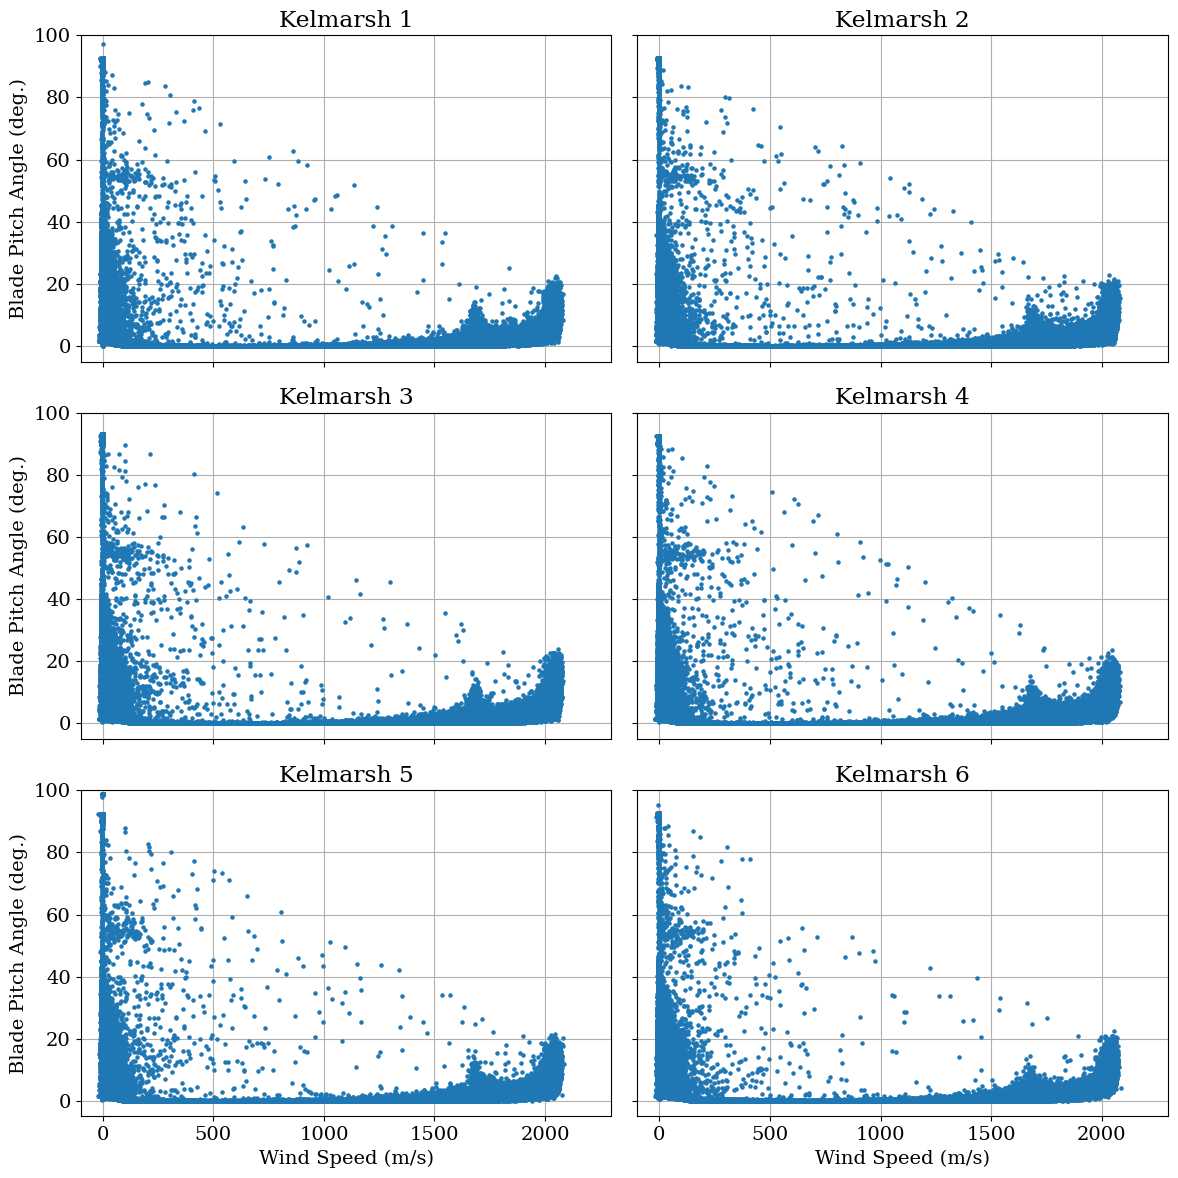

In [6]:
plot.plot_by_id(
    project.scada,
    id_col="asset_id",
    x_axis="WTUR_W",
    y_axis="WROT_BlPthAngVal",
    xlabel="Wind Speed (m/s)",
    ylabel="Blade Pitch Angle (deg.)",
    xlim=(-100, 2300),
    ylim=(-5,100),
    max_cols=2,
    figure_kwargs={"figsize": (12, 12)},
)

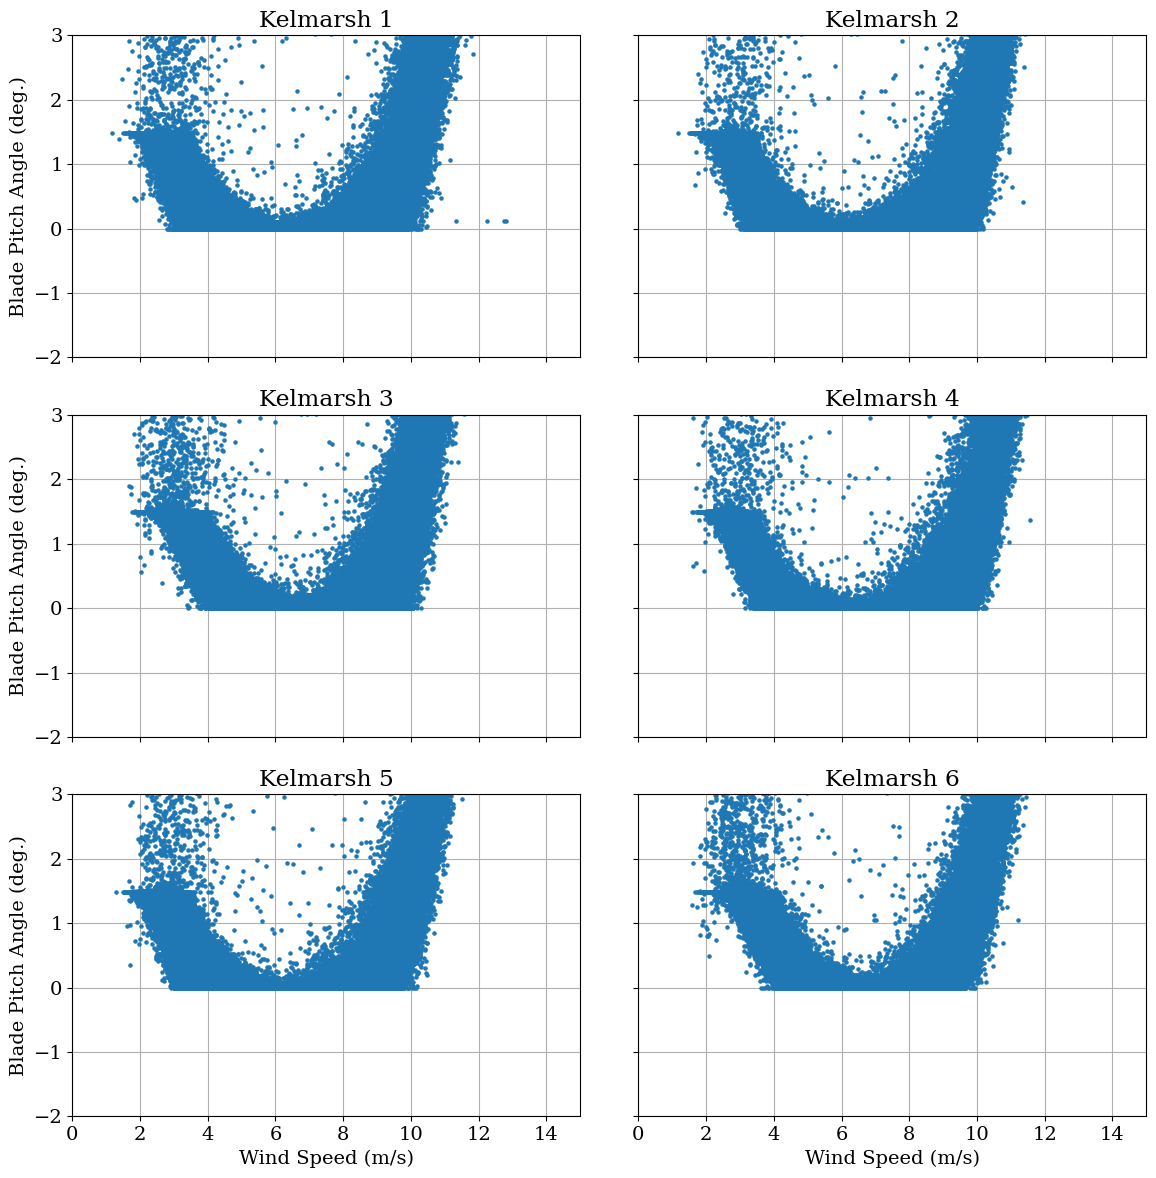

In [7]:
plot.plot_by_id(
    project.scada,
    id_col="asset_id",
    x_axis="WMET_HorWdSpd",
    y_axis="WROT_BlPthAngVal",
    xlabel="Wind Speed (m/s)",
    ylabel="Blade Pitch Angle (deg.)",
    xlim=(0, 15),
    ylim=(-2,3),
    max_cols=2,
    figure_kwargs={"figsize": (12, 12)},
)

Based on the above plots, the pitch angle appears to vary between -1 degree and 0.5 degrees during below-rated operation. Therefore, a pitch threshold of 0.5 degrees seems like the best choice to remove timestamps when the turbine has reached rated power or is being derated. 

Next the static yaw misalignment method applies additional power curve filtering to remove outliers in the power curves caused by derating that were not caught by the pitch threshold filter, severe underperformance, erroneous wind speed or power measurements, etc. This is performed by binning the data by power and removing timestamps for which the wind speed is greater than a certain number of median absolute deviations (MADs) from the median wind speed in each bin. The default threshold is 7 MADs. In the plots below, we'll check to see if the identified outliers appear to be reasonable with this value. 

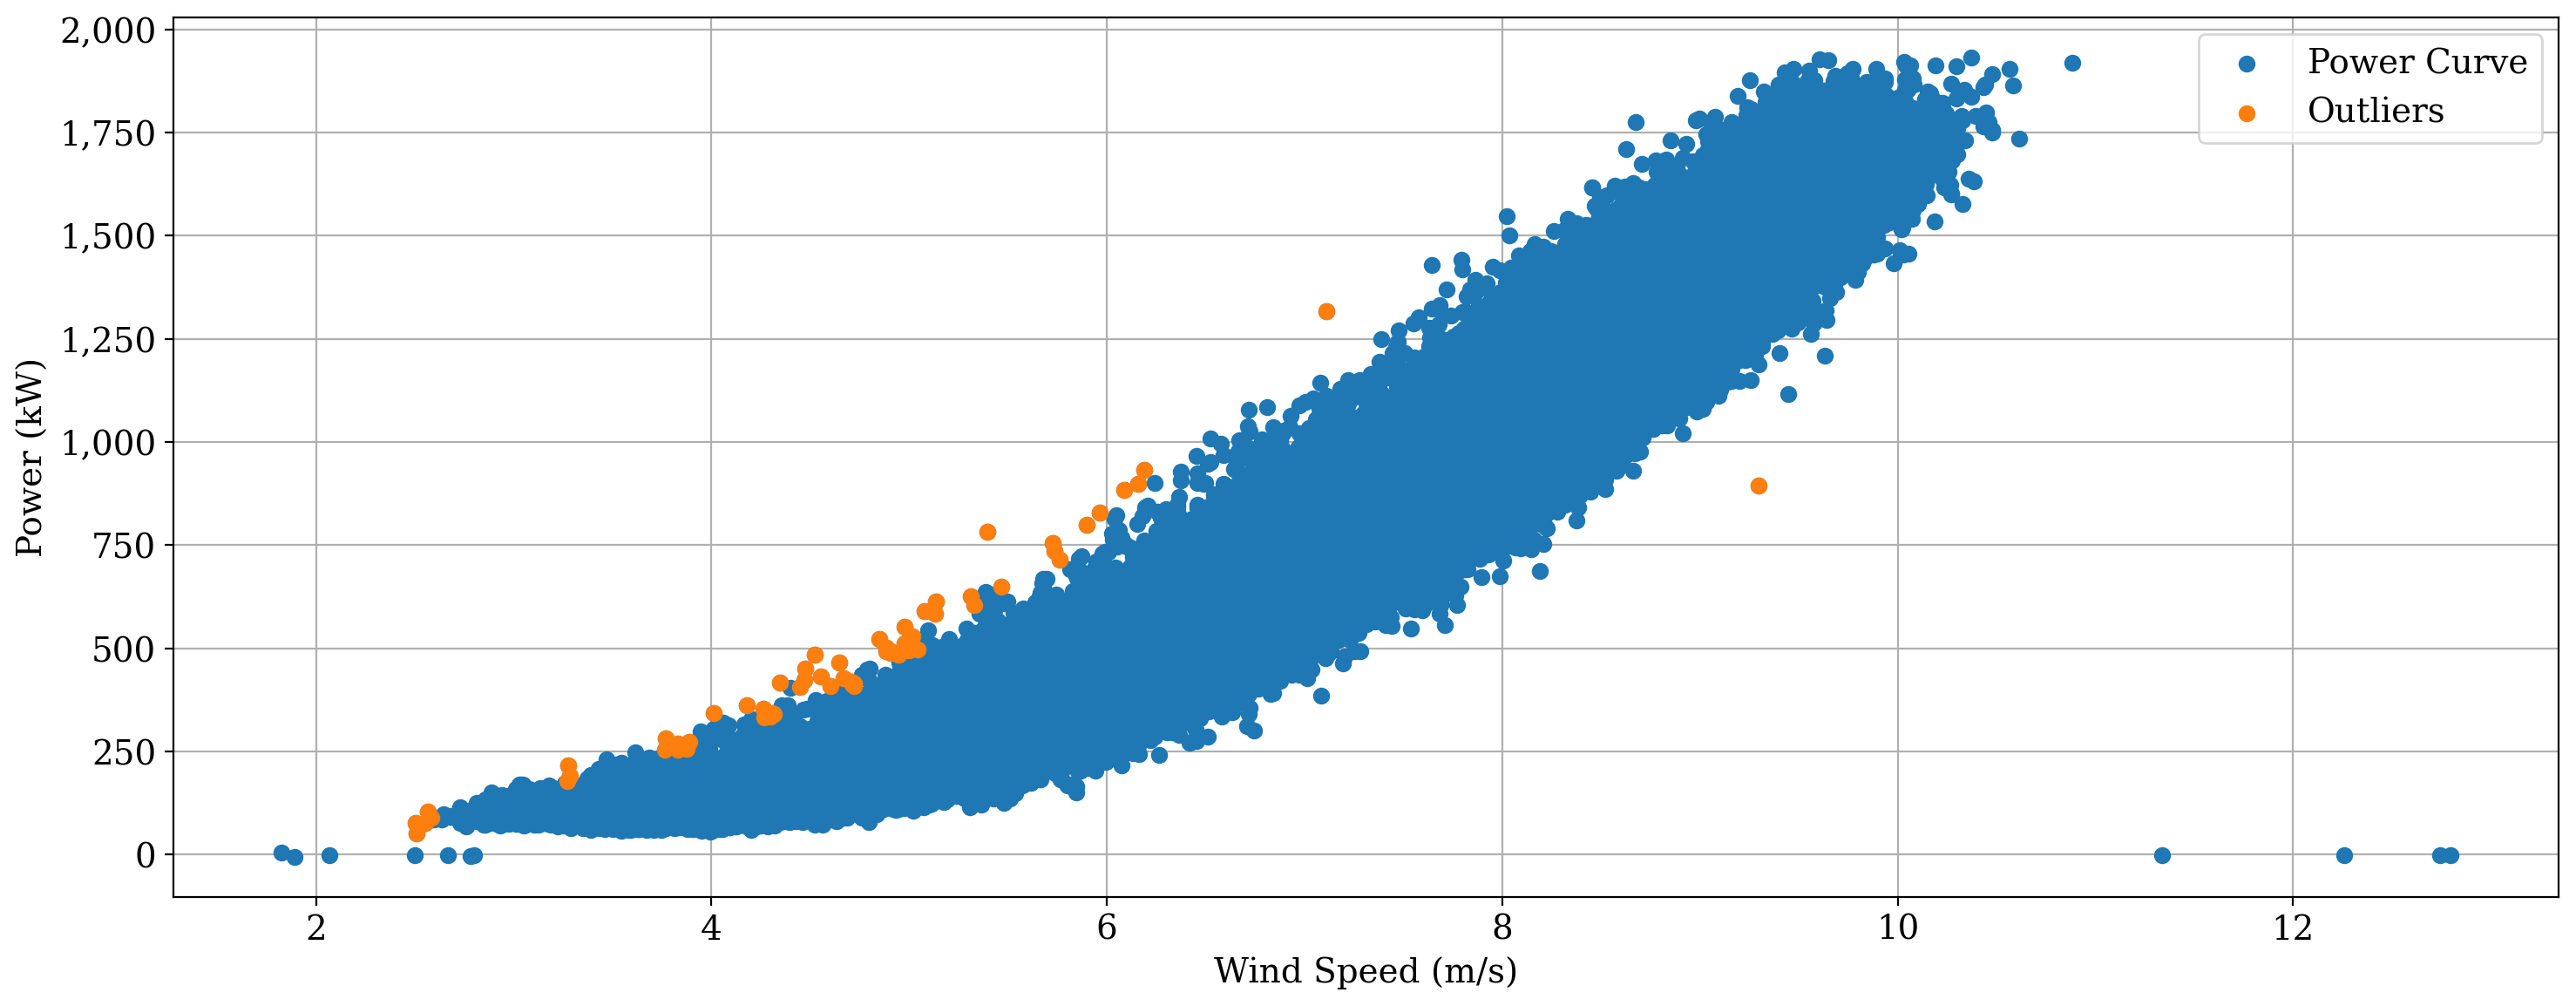

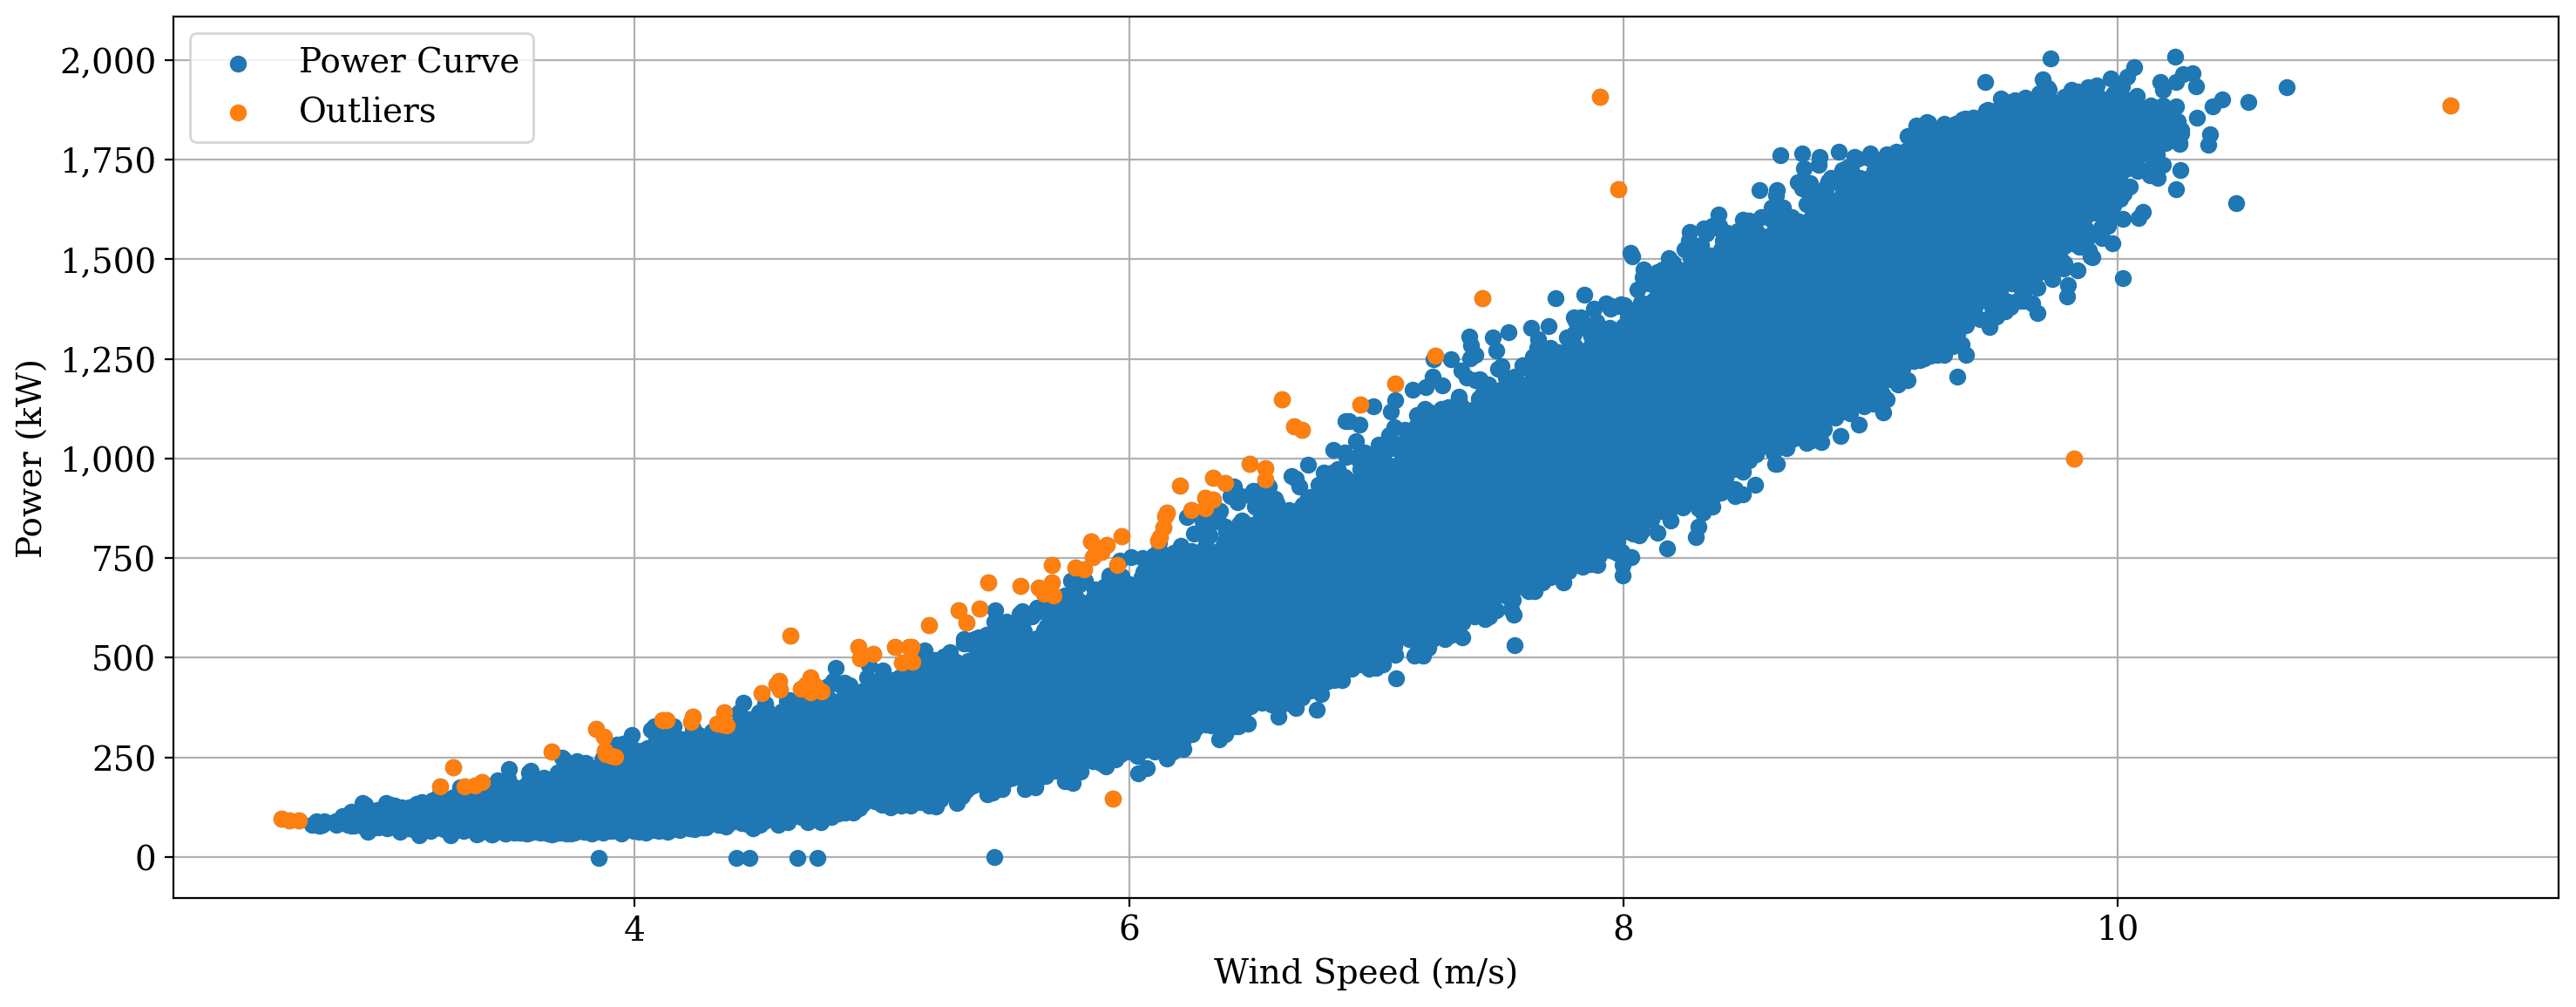

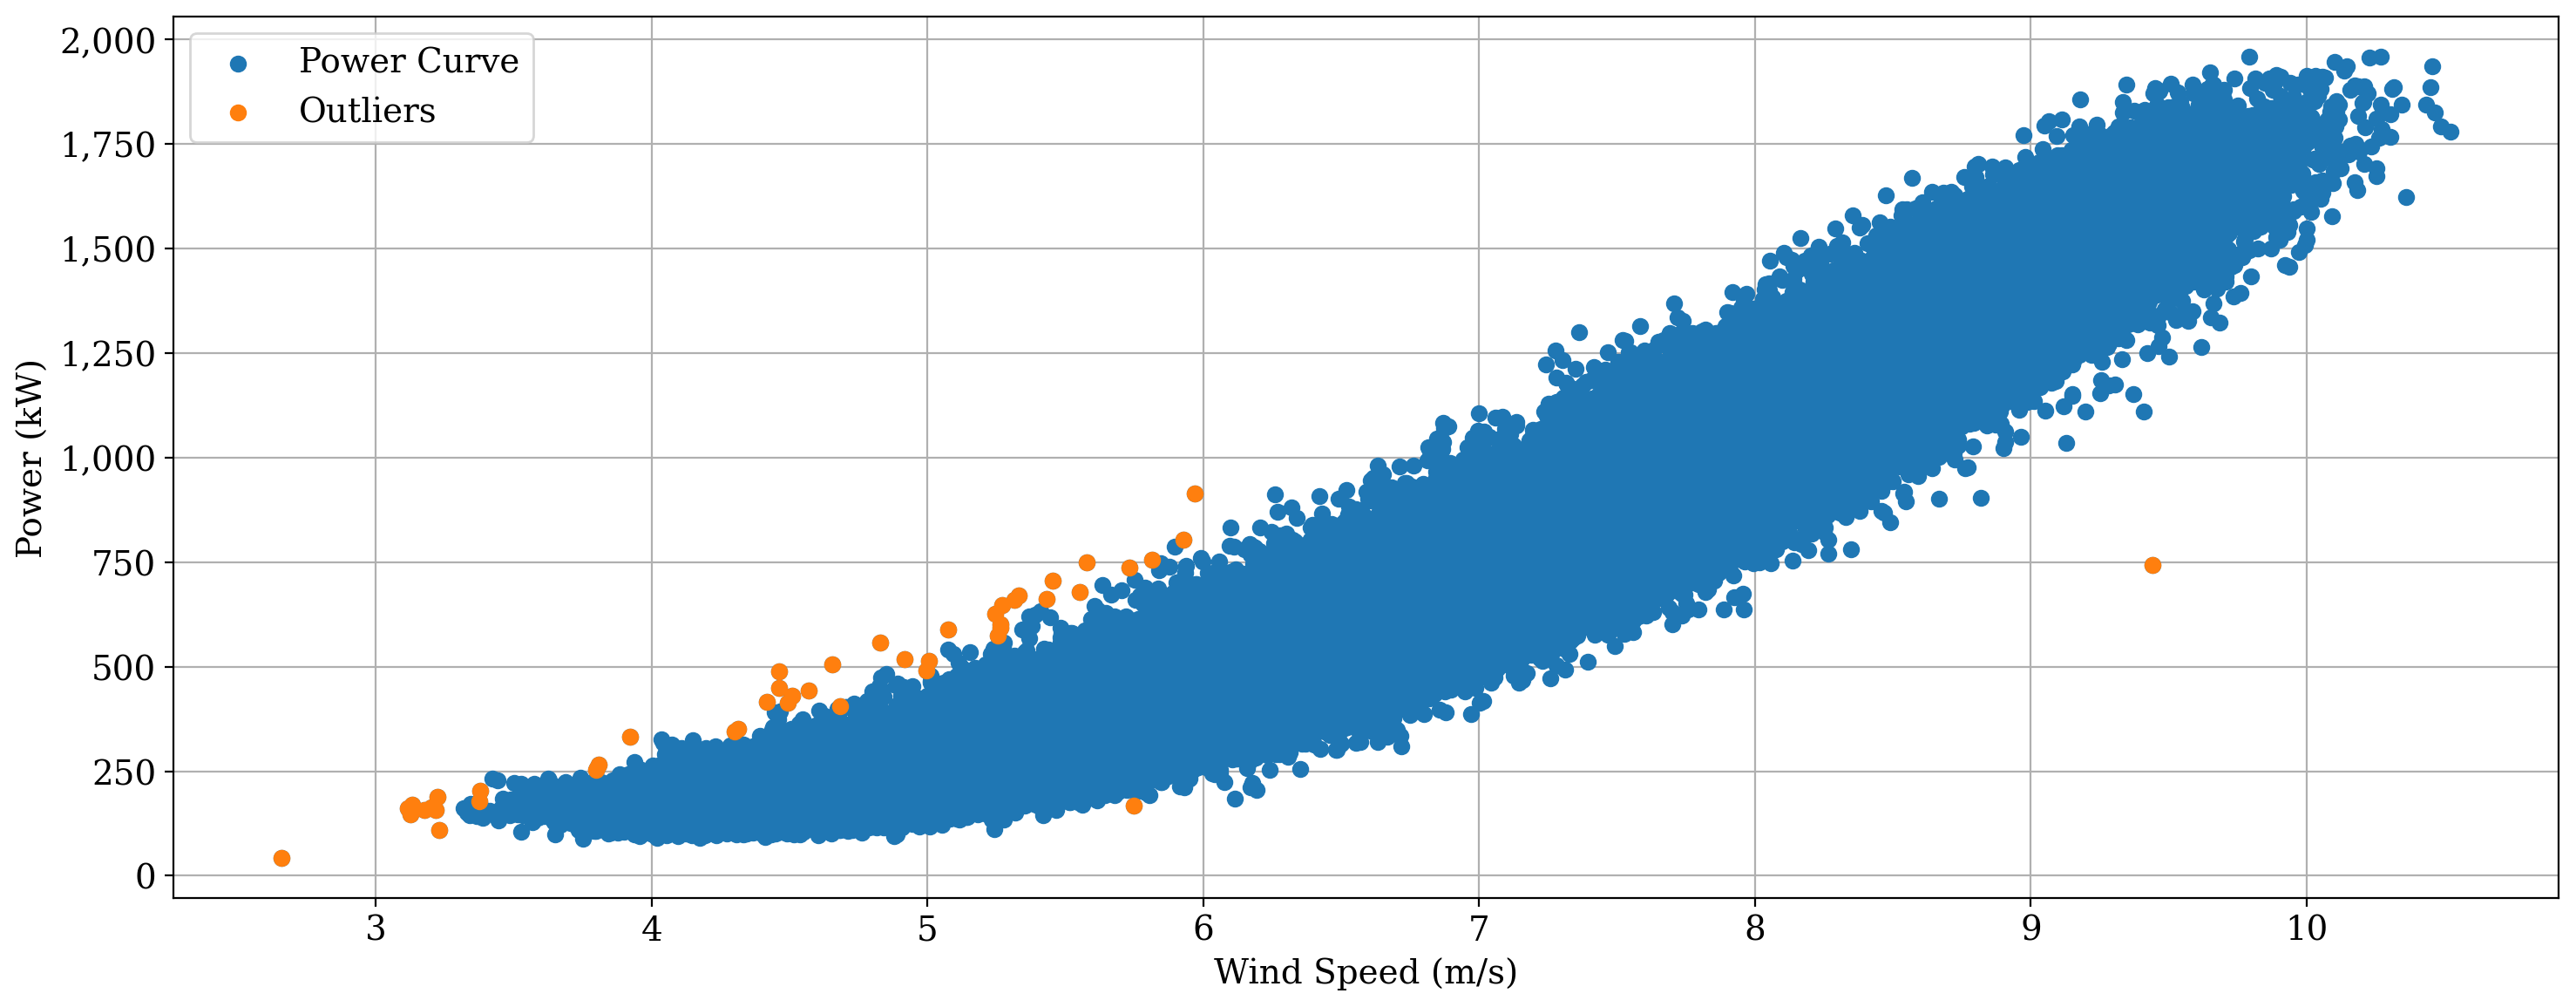

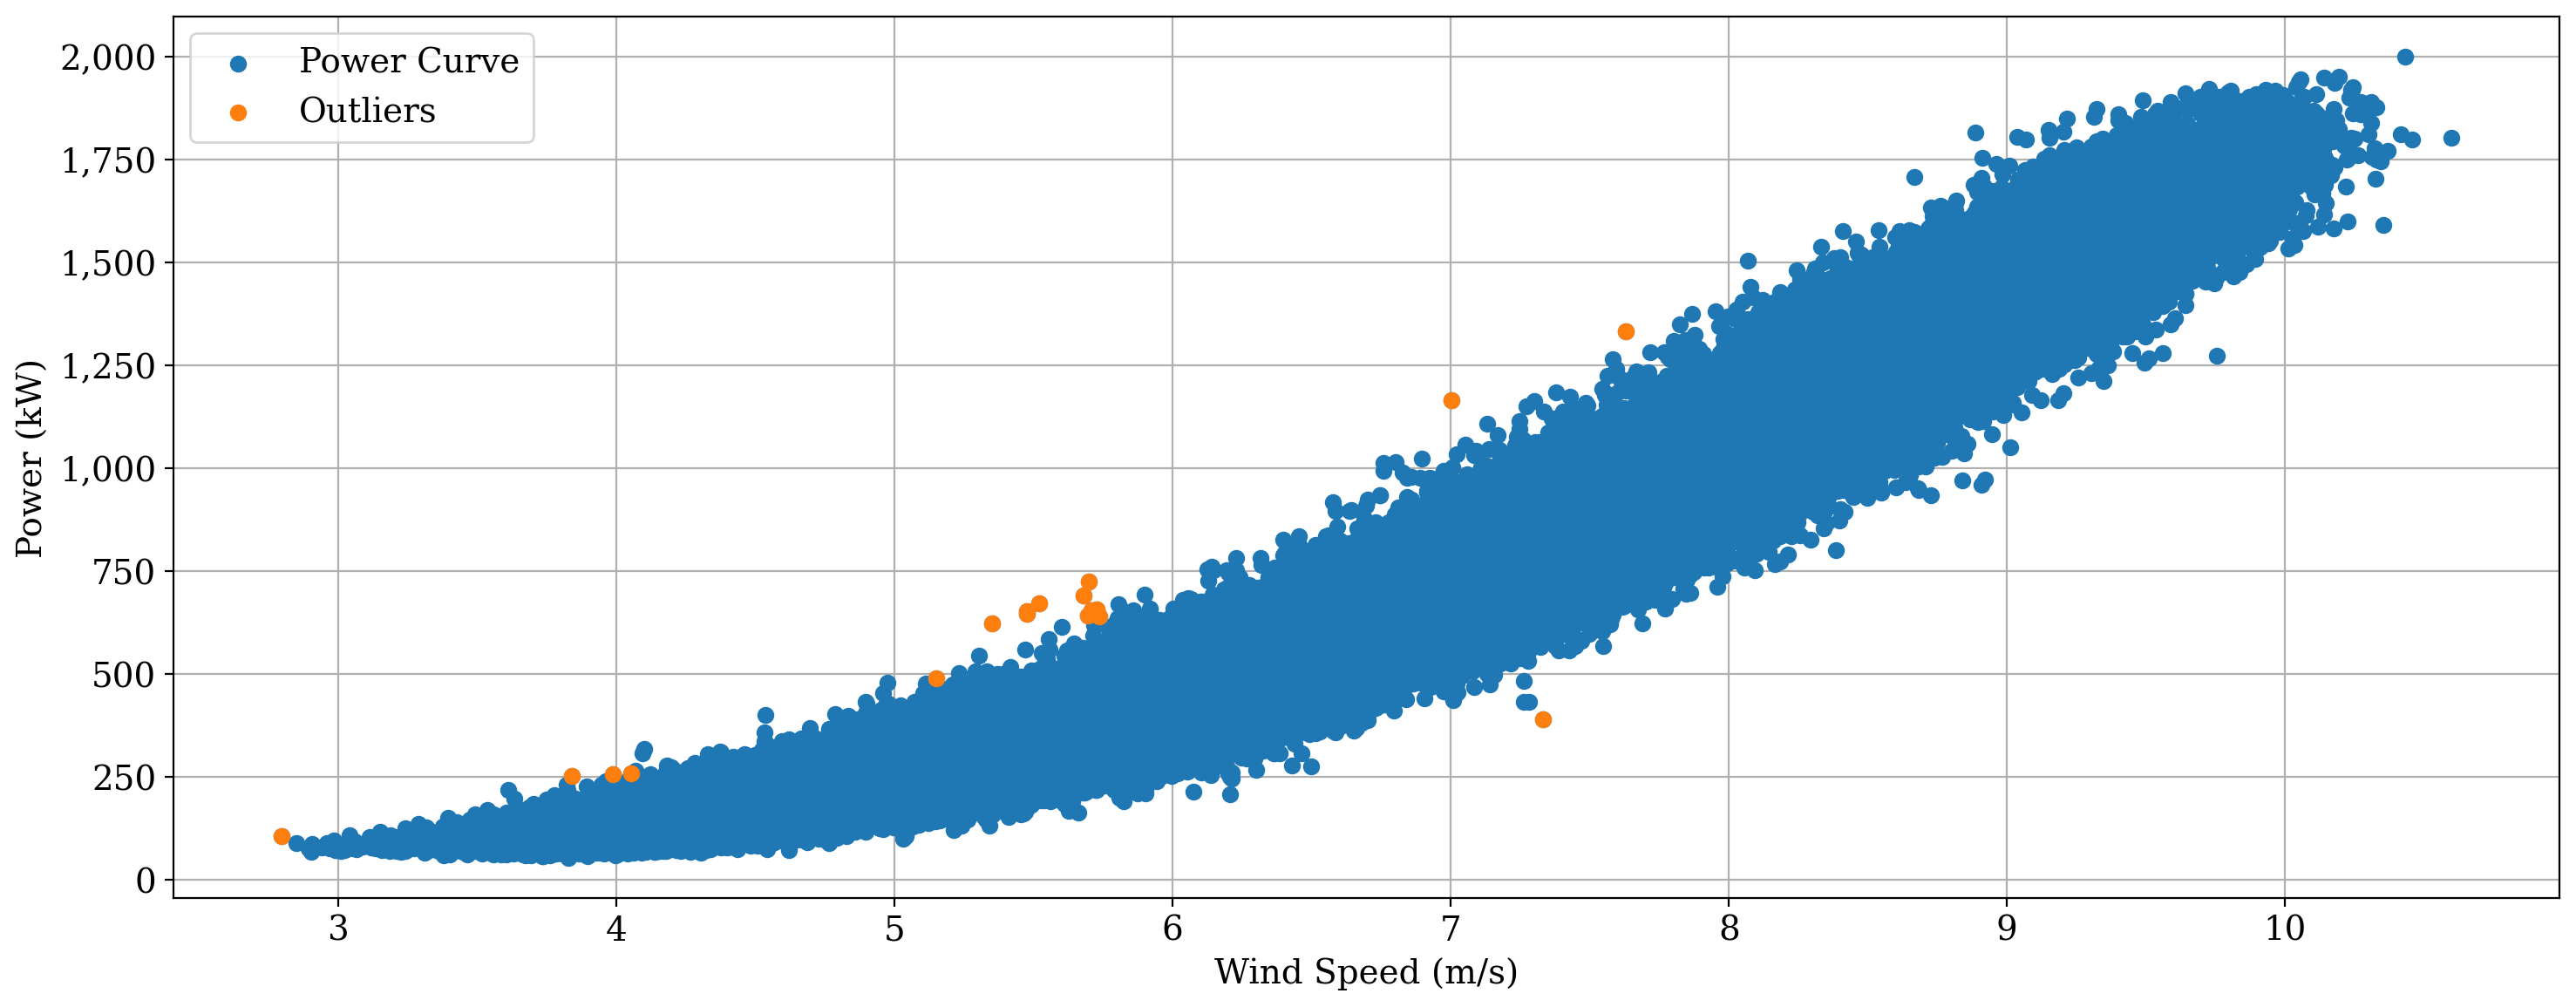

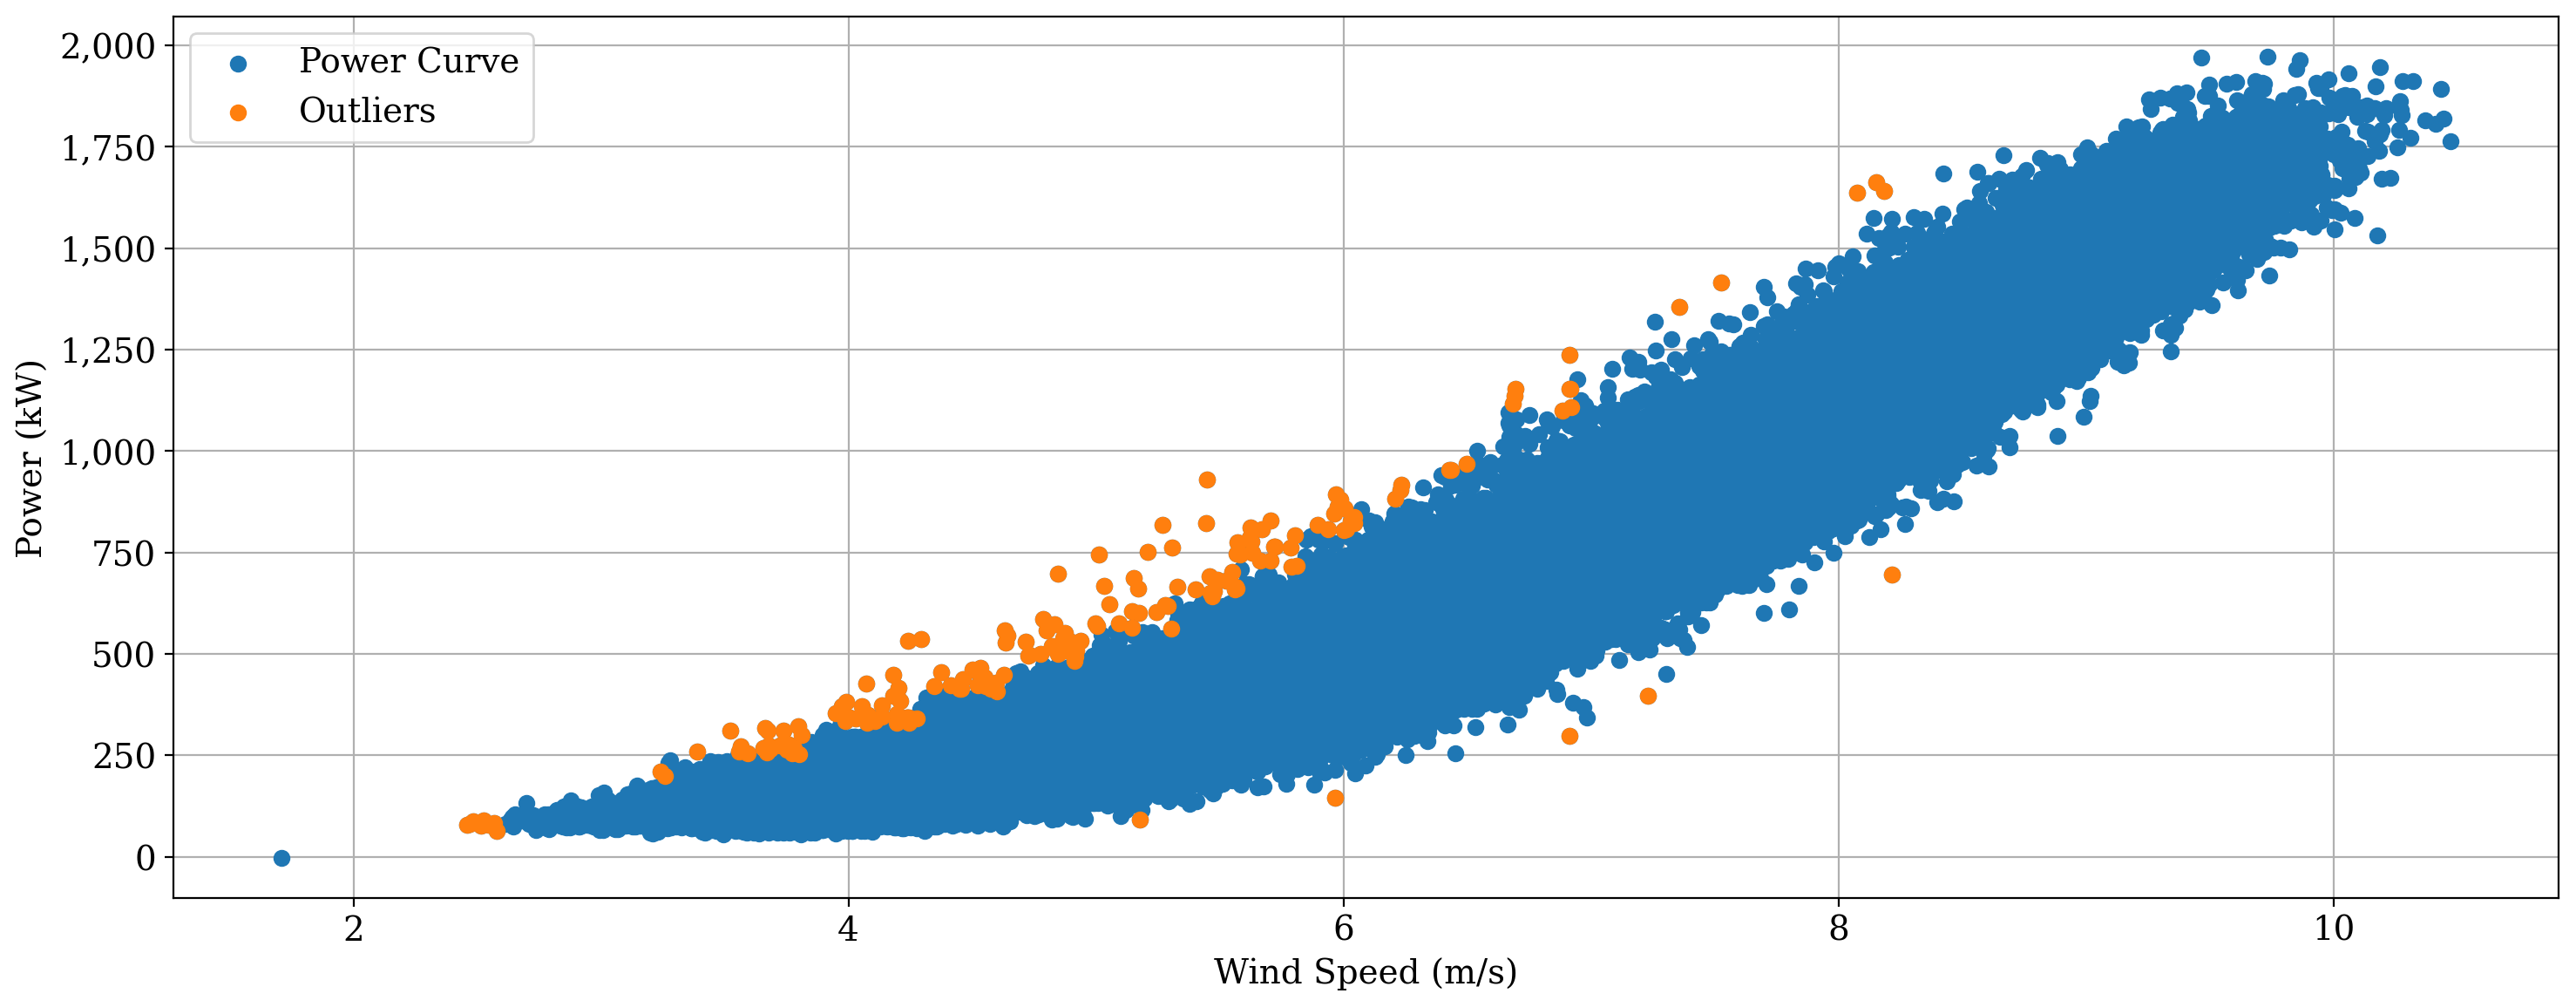

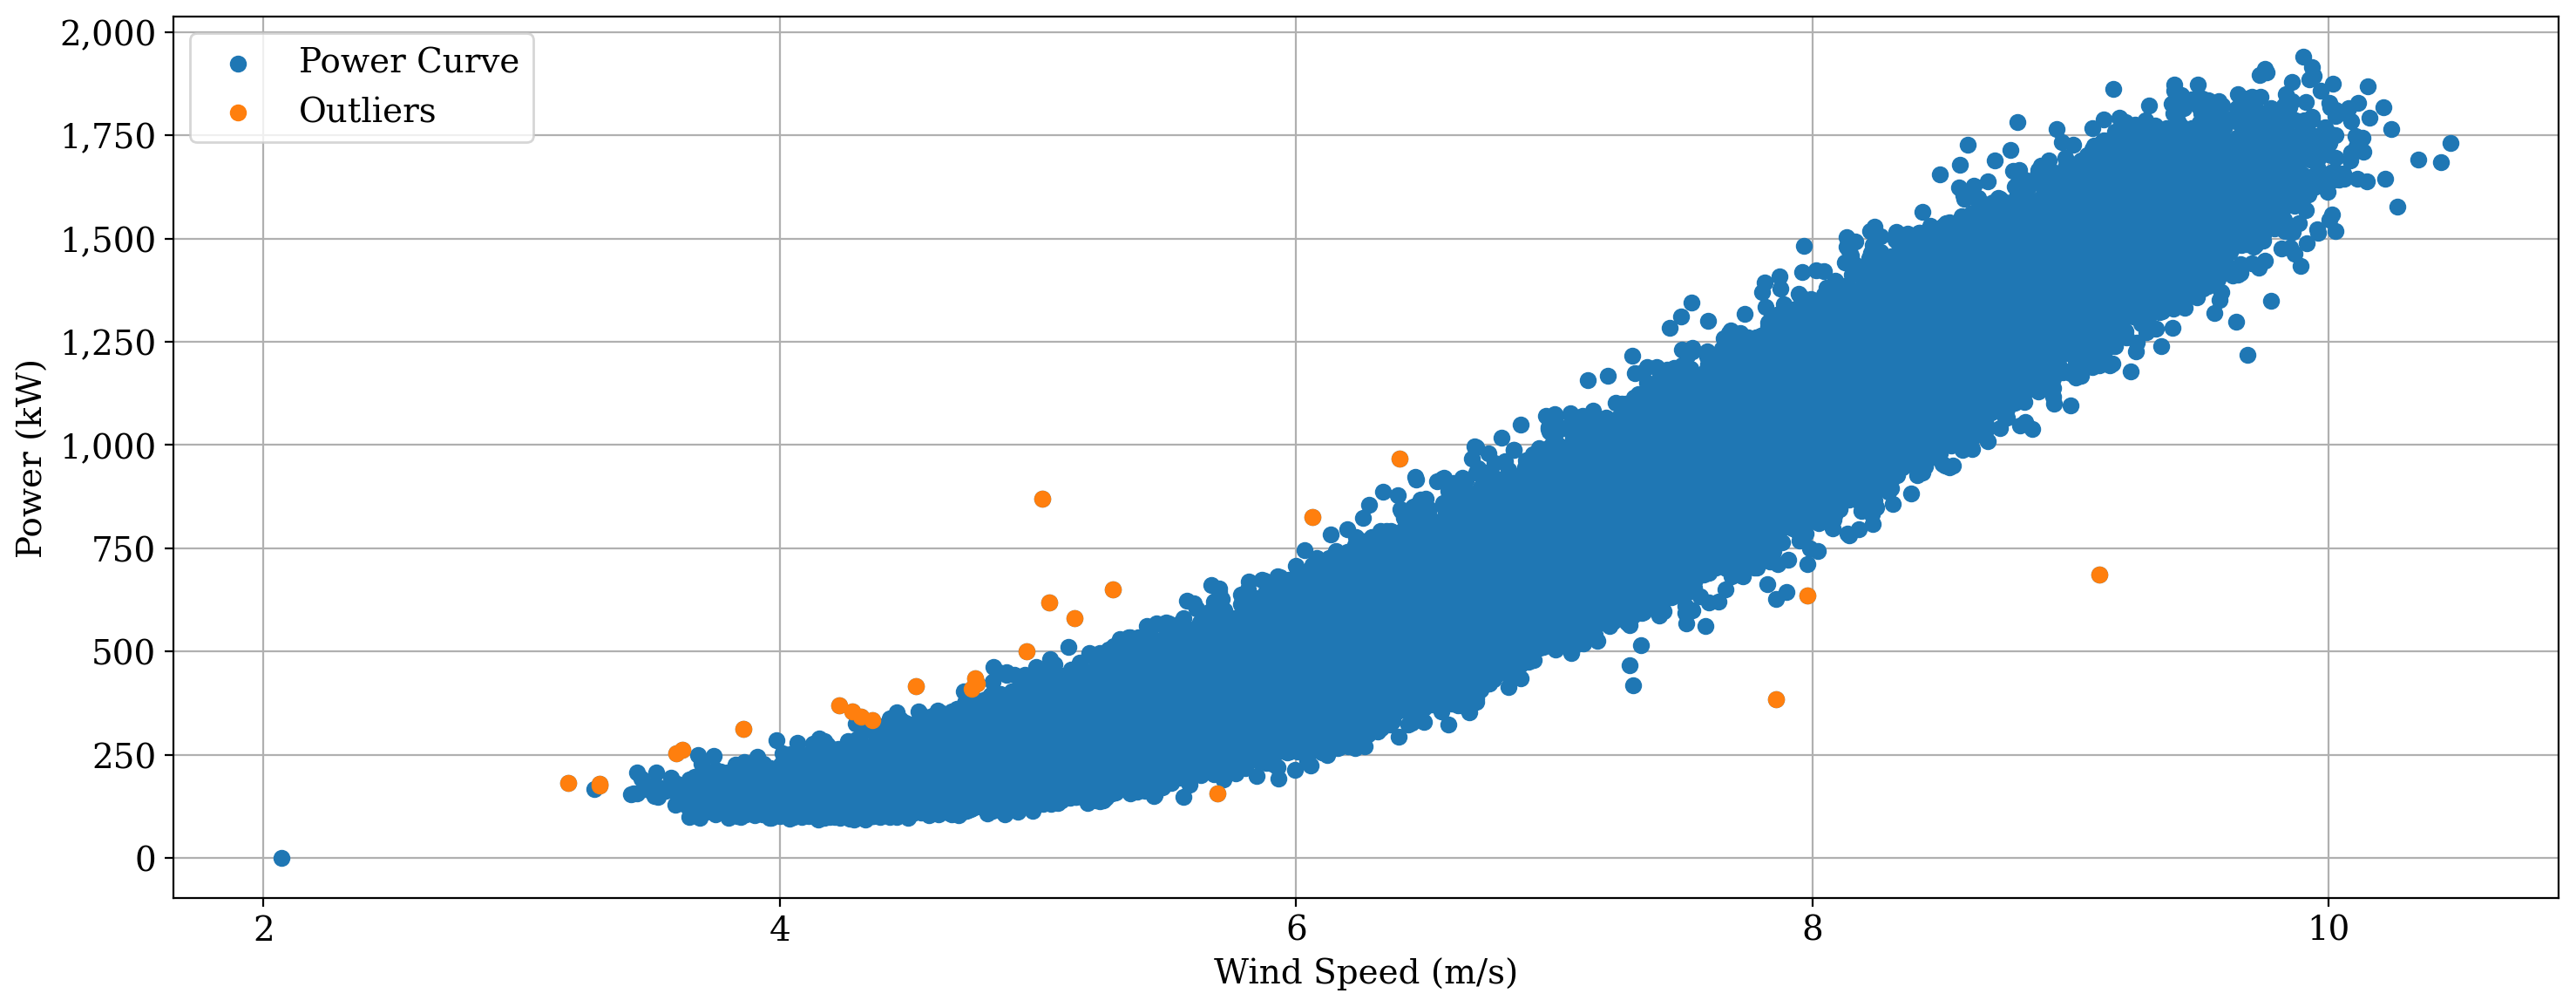

In [8]:
pitch_threshold = 0.5
power_bin_mad_thresh = 7.0

for t in project.turbine_ids:
    
    # TODO: apply bin power curve filtering
    df_sub = project.scada.loc[(slice(None), t),:]
    df_sub = df_sub.loc[df_sub["WROT_BlPthAngVal"] <= pitch_threshold]
    
    # Apply power bin filter
    turb_capac=project.asset.loc[t, "rated_power"]
    flag_bin=filters.bin_filter(
        bin_col=df_sub["WTUR_W"],
        value_col=df_sub["WMET_HorWdSpd"],
        bin_width=0.04 * 0.94 * turb_capac,
        threshold=power_bin_mad_thresh,
        center_type="median",
        bin_min=0.01 * turb_capac,
        bin_max=0.95 * turb_capac,
        threshold_type="mad",
        direction="all",
    )

    plot.plot_power_curve(
        wind_speed=df_sub["WMET_HorWdSpd"],
        power=df_sub["WTUR_W"],
        flag=flag_bin,
        flag_labels=("Outliers", "Power Curve"),
        legend=True
    )

Based on the plots above, using a bin filter threshold of 7 MADs identifies obvious outliers without removing too many points that seem normal. Therefore, we'll use the default value of 7.

## Yaw misalignment detection without uncertainty quantification

First, we'll create a `StaticYawMisalignment` object without uncertainty quantification (`UQ=False`) using our `PlantData` object called `project` for La Haute Borne. By setting the argument `turbine_ids` to its default value of None, yaw misalignment will be detected for all turbines in the wind plant. To analyze only specific wind turbines, `turbine_ids` can be set to the list of turbine names of interest.

In [9]:
yaw_mis = StaticYawMisalignment(
    plant=project,
    turbine_ids=None,
    UQ=False
)

Next, we'll run the static yaw misalignment analysis method, which contains the following arguments.

  - `num_sim`: The number of Monte Carlo iterations to perform to quantify uncertainty. This argument is ignored here because we set `UQ=False`; only one iteration will be performed.
  - `ws_bins`: The wind speed bin centers for which yaw msialignment detection will be performed (m/s). We'll look at wind speeds from 4 to 10 m/s, which appear to contain sufficient data for analyzing power vs. yaw misalignment based on the power curve plots shown earlier.
  - `ws_bin_width`: The wind speed bin size to use when detecting yaw misalignment for individual wind speed bins (m/s). We'll use the default value of 1 m/s. 
  - `vane_bin_width`: The wind vane bin size to use when computing power performance as a function of vane angle to detect yaw misalignment (degrees). Again, we'll use the default value, which is 1 degree.
  - `min_vane_bin_count`: The minimum number of data points needed in a wind vane bin for it to be included when detecting yaw misalignment. We will use a value of 50 to ensure that we are not including bins for which very few timestamps are available, which could lead to high uncertainty in the results.
  - `max_abs_vane_angle`: The maximum absolute wind vane angle considered when detecting yaw misalignment (degrees). We're using the default value of 25 degrees.
  - `pitch_thresh`: As discussed earlier, this is the maximum blade pitch angle considered when detecting yaw misalignment (degrees). We determined that the default value of 0.5 degrees is an appropriate choice.
  - `max_power_filter`: The maximum power, defined as a fraction of rated power, to which a power curve bin filter will be applied to identify abnormal turbine operation.
  - `power_bin_mad_thresh`: The filter threshold for each power bin used to identify abnormal operation, expressed as the number of median absolute deviations from the median wind speed in the power bin. As discussed above, the default value of 7 will be used.
  - `use_power_coeff`: If `True`, power performance as a function of wind vane angle will be quantified by normalizing power by the cube of the wind speed, approximating the power coefficient. If `False`, only power will be used. We will try setting this to `True` to normalize by wind speed cubed. This can help account for variations in power within a wind speed bin caused by differences in wind speed.

In [10]:
yaw_mis.run(
    num_sim=1,
    ws_bins=[5.0, 6.0, 7.0, 8.0, 9.0, 10.0],
    ws_bin_width=1.0,
    vane_bin_width=1.0,
    min_vane_bin_count=50,
    max_abs_vane_angle=25.0,
    pitch_thresh=pitch_threshold,
    max_power_filter=0.95,
    power_bin_mad_thresh=power_bin_mad_thresh,
    use_power_coeff=True
)

100%|██████████| 1/1 [00:02<00:00,  2.99s/it]


Now, we'll print the yaw misalignment averaged over all wind speed bins for each turbine. 

The estimated overall amount of yaw misalignment for the four turbines is between approximately 1 and 3 degrees.  

In [11]:
for i, t in enumerate(yaw_mis.turbine_ids):
    print(f"Overall yaw misalignment for Turbine {t}: {np.round(yaw_mis.yaw_misalignment[i],1)} degrees")

Overall yaw misalignment for Turbine Kelmarsh 1: -21.1 degrees
Overall yaw misalignment for Turbine Kelmarsh 2: -25.0 degrees
Overall yaw misalignment for Turbine Kelmarsh 3: -23.6 degrees
Overall yaw misalignment for Turbine Kelmarsh 4: -21.4 degrees
Overall yaw misalignment for Turbine Kelmarsh 5: -12.1 degrees
Overall yaw misalignment for Turbine Kelmarsh 6: -15.6 degrees


To better understand how these yaw misalignment values were estimated and how the yaw misalignment varies for different wind speed bins, we'll plot the power performance as a function of wind vane angle for each wind speed bin and each turbine.

The plots below show the binned normalized coefficients of power as a function of wind vane angle, the best-fit cosine-exponent curves, the wind vane angles at which power performance is maximized based on the best-fit curves, and the mean wind vane angles at which the turbines operate. For a given turbine and wind speed bin, the yaw misalignment is then estimated as the difference between the vane angle where power is maximized and the mean vane angle at which the turbine operates.

  valid_vane_indices = np.where(~np.isnan(np.nanmean(power_values_vane_ws, 0)))[0]



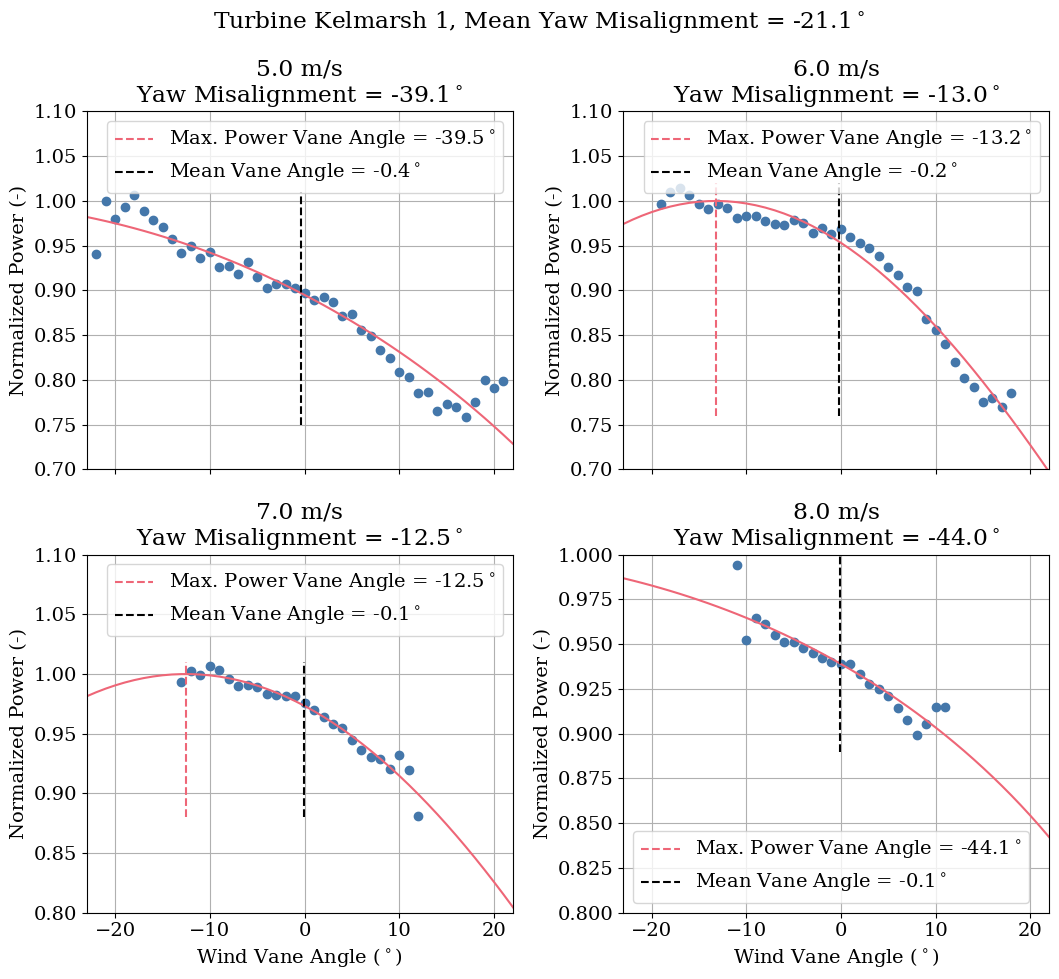

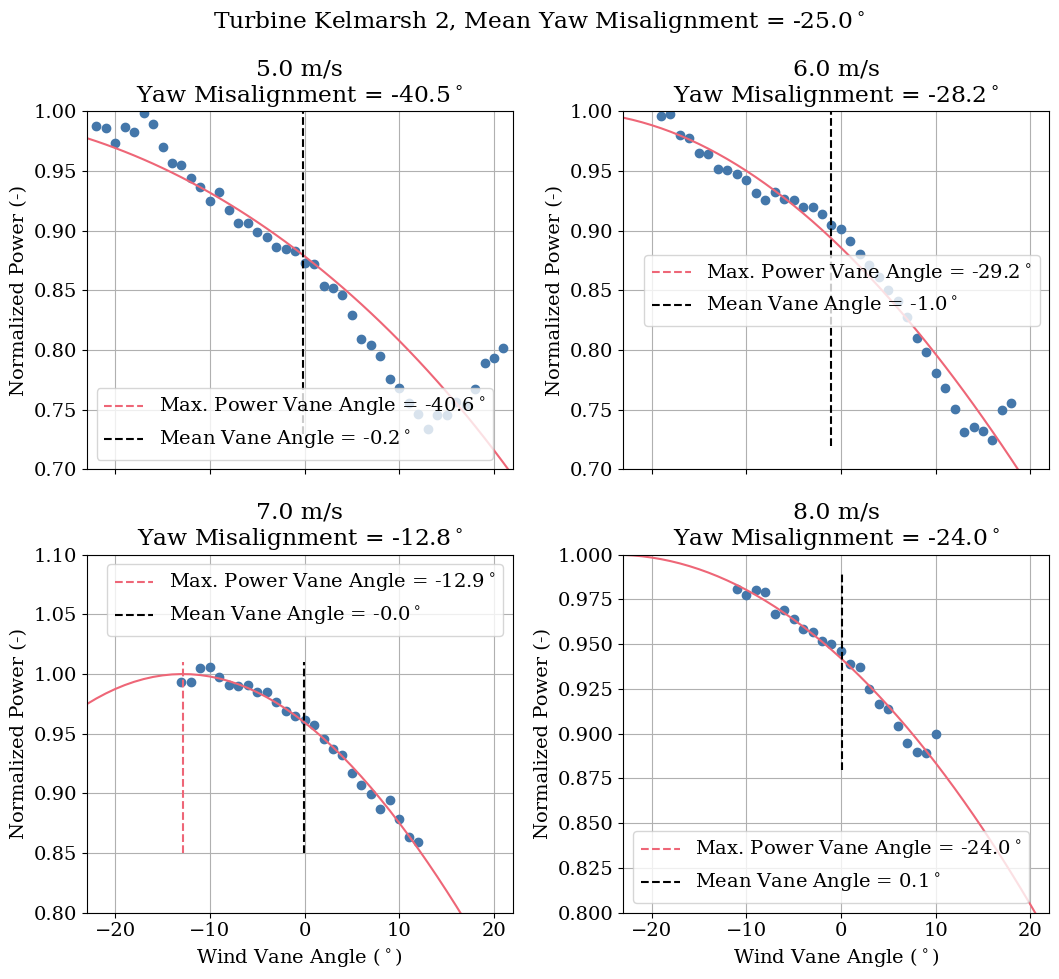

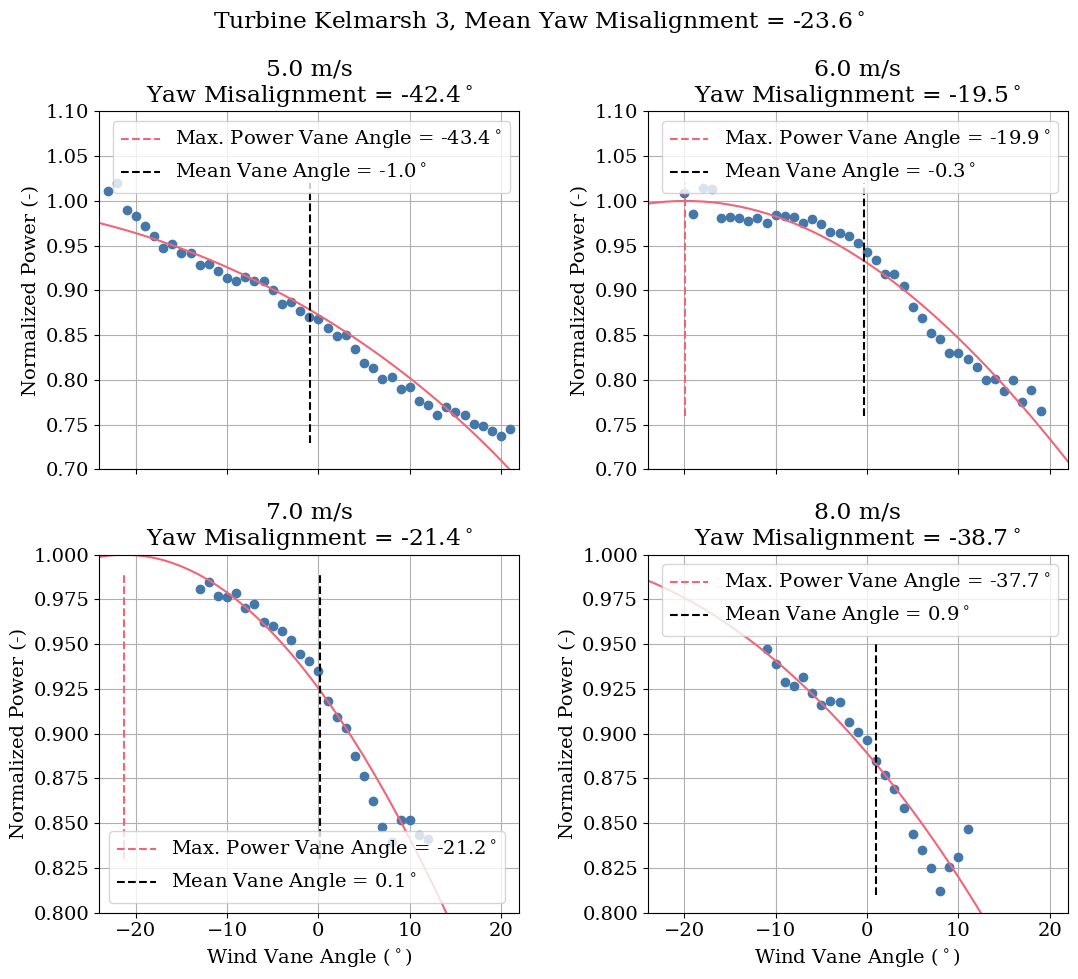

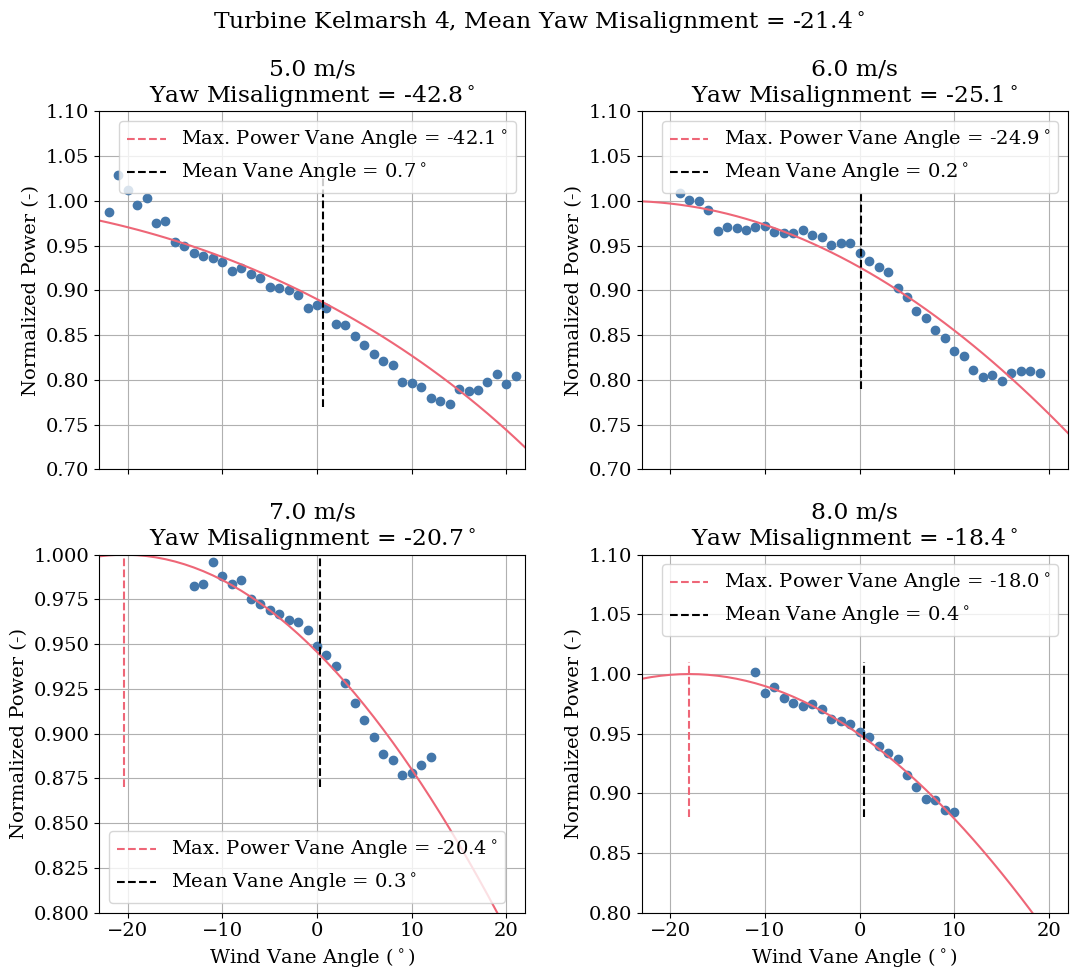

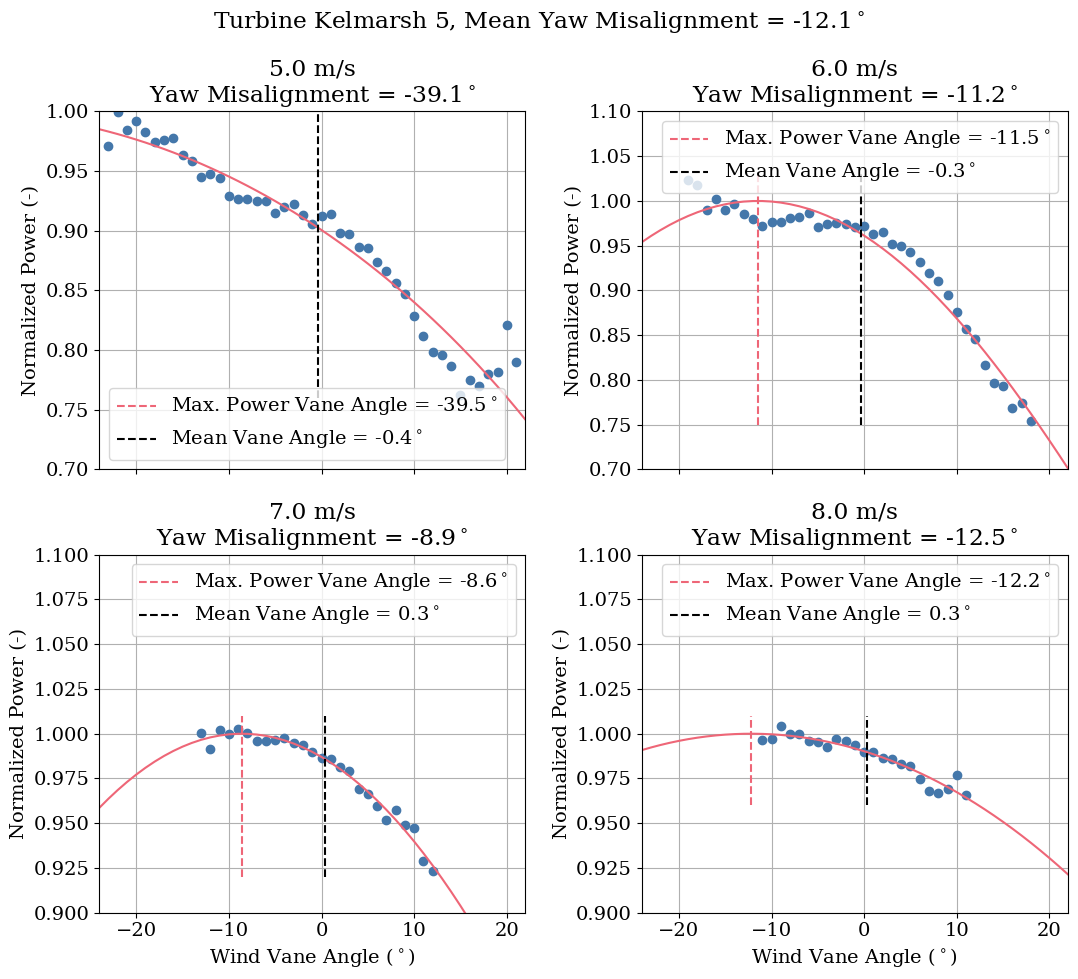

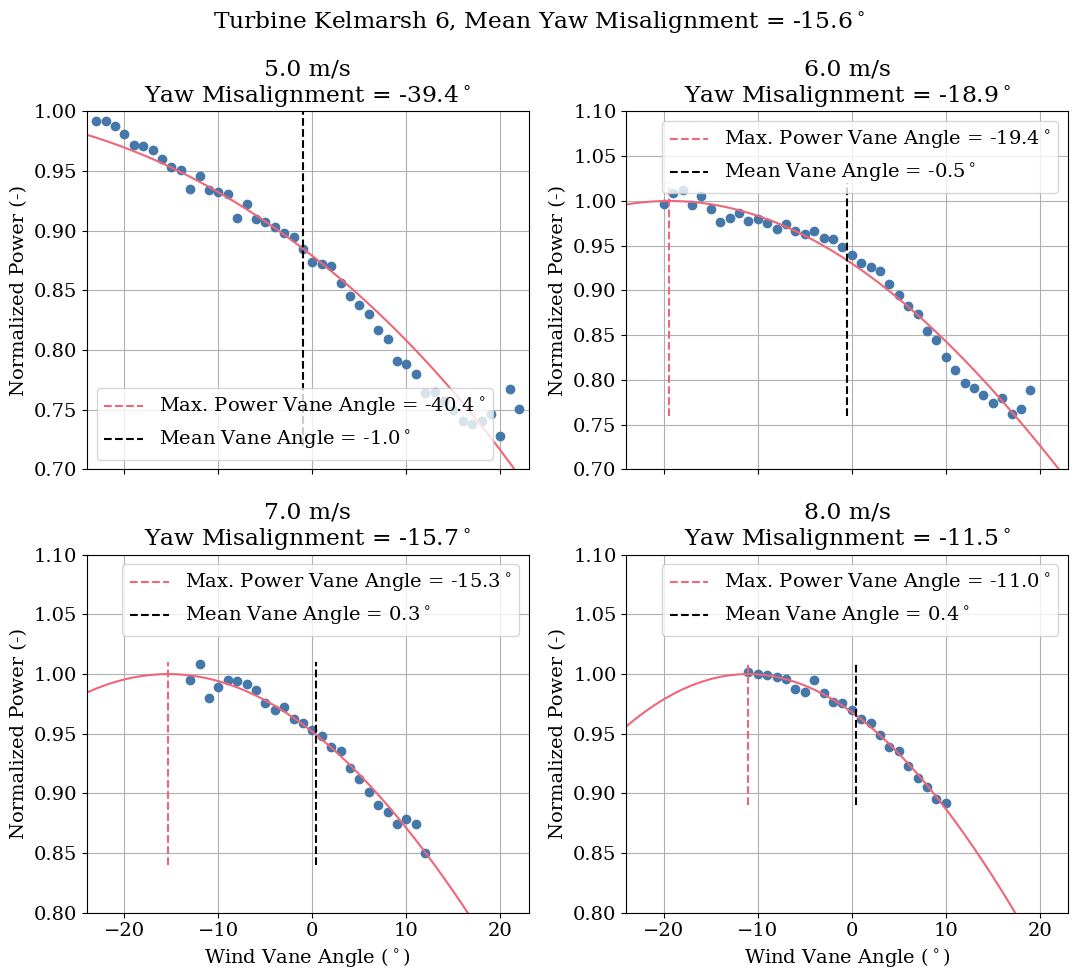

In [12]:
axes_dict = yaw_mis.plot_yaw_misalignment_by_turbine(return_fig = True)

The plots above reveal that for all turbines the estimated yaw misalignment is relatively small (within +/- 1-2 degrees) for lower wind speeds. But larger positive yaw misalignments (up to 4-8 degrees) are estimated for higher wind speeds. For turbines R80711 and R80736, larger positive yaw misalignments between 2-7 degrees are estiamted for the 9 m/s and 10 m/s wind speed bins. For turbines R80721 and R80790, yaw misalignments between 4-8 degrees are estimated for wind speed bins from 8-10 m/s. Consequently, the overall yaw misalignments averaged over all wind speed bins are close to 1 degree for turbines R80711 and R80736 and near 3 degrees for turbines R80721 and R80790. 

In general, the wind speed dependence of the yaw misalignment can be attributed to changes in the flow encountered by the nacelle wind vane behind the turbine rotor due to changes in rotor speed and thrust as a function of wind speed.

Note that although the average yaw misalgnment for the wind speed bins investigated is a simple and useful metric, it may not necessarily be the most relevant indication of the overall yaw misalignment. An alternative approach for determining the effective overall yaw misalignment, which is outside the scope of the current version of `StaticYawMisalignment`, could include computing a weighted average of the yaw misalignment values in each wind speed bin. For example, the wind speed-dependent yaw misalignment estimates could be weighted by the amount of energy produced at each wind speed or the estimated amount of energy lost at each wind speed. An improved method for quantifying the overall yaw misalignment may be considered in future versions of the software.    

## Yaw misalignment detection with uncertainty quantification

Next, we'll repeat the yaw misalignment detection process by creating a new `StaticYawMisalignment` object, but this time with uncertainty quantification enabled (`UQ=True`).

In [13]:
yaw_mis = StaticYawMisalignment(
    plant=project,
    turbine_ids=None,
    UQ=True
)

Next, we'll run the static yaw misalignment analysis with uncertainty quantification. Because many of the arguments are the same as for the case without uncertainty quantification, only the arguments that are different are described below. For each tuple argument, during each Monte Carlo iteration a random value will be chosen in the range between the minimum and maximum values specified. 

  - `num_sim`: The number of Monte Carlo iterations to perform to quantify uncertainty. We will perform the default of 100 iterations.
  - `max_power_filter`: The range (minimum and maximum) of maximum power values, defined as a fraction of rated power, to which a power curve bin filter will be applied to identify abnormal turbine operation. We'll use the default range of 0.92 to 0.98.
  - `power_bin_mad_thresh`: The minimum and maximum filter thresholds for each power bin used to identify abnormal operation, expressed as the number of median absolute deviations from the median wind speed in the power bin. The default range of 4 to 10 will be used.

Although the power curve filtering parameters described above are randomly sampled each Monte Carlo iteration, the primary method of quantifying uncertainty is bootstrapping. Each iteration, sets of timestamps sampled randomly with replacement are used to compute static yaw misalignment for each wind turbine and wind speed bin.

Note: with 100 iterations, this command can take a minute or so to execute.

In [14]:
yaw_mis.run(
    num_sim=100,
    ws_bins=[5.0, 6.0, 7.0, 8.0, 9.0, 10.0],
    ws_bin_width=1.0,
    vane_bin_width=1.0,
    min_vane_bin_count=50,
    max_abs_vane_angle=25.0,
    pitch_thresh=pitch_threshold,
    max_power_filter=(0.92, 0.98),
    power_bin_mad_thresh=(4.0, 10.0),
    use_power_coeff=True
)

100%|██████████| 100/100 [04:50<00:00,  2.90s/it]


Now, based on the results from the 100 Monte Carlo iterations, we'll print the mean yaw misalignment values averaged over all wind speed bins for each turbine together with the standard deviations and 95% confidence intervals. 

The mean overall yaw misalignment values are similar to the values estimated without uncertainty. The corresponding standard deviations range from approximately 0.2 degrees to 2 degrees depending on the turbine (results will vary slightly each time the method is run).

The 95% confidence intervals are very large for turbines R80711 and R80721 (spanning up to 5 degrees or more), but are relatively small for turbines R80736 and R80790 (representing approximately 1 degree of uncertainty). 

In [15]:
for i, t in enumerate(yaw_mis.turbine_ids):
    print(f"Mean overall yaw misalignment for Turbine {t}: {np.round(yaw_mis.yaw_misalignment_avg[i],1)} degrees")
    print(f"Std. Dev. of overall yaw misalignment for Turbine {t}: {np.round(yaw_mis.yaw_misalignment_std[i],1)} degrees")
    print(f"95% confidence interval of overall yaw misalignment for Turbine {t}: [{np.round(yaw_mis.yaw_misalignment_95ci[i,0],1)} deg., {np.round(yaw_mis.yaw_misalignment_95ci[i,1],1)} deg.]")


Mean overall yaw misalignment for Turbine Kelmarsh 1: -21.5 degrees
Std. Dev. of overall yaw misalignment for Turbine Kelmarsh 1: 4.4 degrees
95% confidence interval of overall yaw misalignment for Turbine Kelmarsh 1: [-30.7 deg., -12.0 deg.]
Mean overall yaw misalignment for Turbine Kelmarsh 2: -28.7 degrees
Std. Dev. of overall yaw misalignment for Turbine Kelmarsh 2: 5.1 degrees
95% confidence interval of overall yaw misalignment for Turbine Kelmarsh 2: [-40.1 deg., -20.7 deg.]
Mean overall yaw misalignment for Turbine Kelmarsh 3: -24.3 degrees
Std. Dev. of overall yaw misalignment for Turbine Kelmarsh 3: 3.2 degrees
95% confidence interval of overall yaw misalignment for Turbine Kelmarsh 3: [-33.7 deg., -19.8 deg.]
Mean overall yaw misalignment for Turbine Kelmarsh 4: -23.4 degrees
Std. Dev. of overall yaw misalignment for Turbine Kelmarsh 4: 2.9 degrees
95% confidence interval of overall yaw misalignment for Turbine Kelmarsh 4: [-31.1 deg., -19.8 deg.]
Mean overall yaw misalignmen

To understand why uncertainty is significantly higher for two of the turbines, for each turbine and each wind speed bin we'll plot power performance as a function of wind vane angle with uncertainty included. The shaded regions in the plots below and the yaw misalignment values in brackets indicate 95% confidence intervals. 

  return function_base._ureduce(a,

  valid_vane_indices = np.where(~np.isnan(np.nanmean(power_values_vane_ws, (0, 1))))[0]



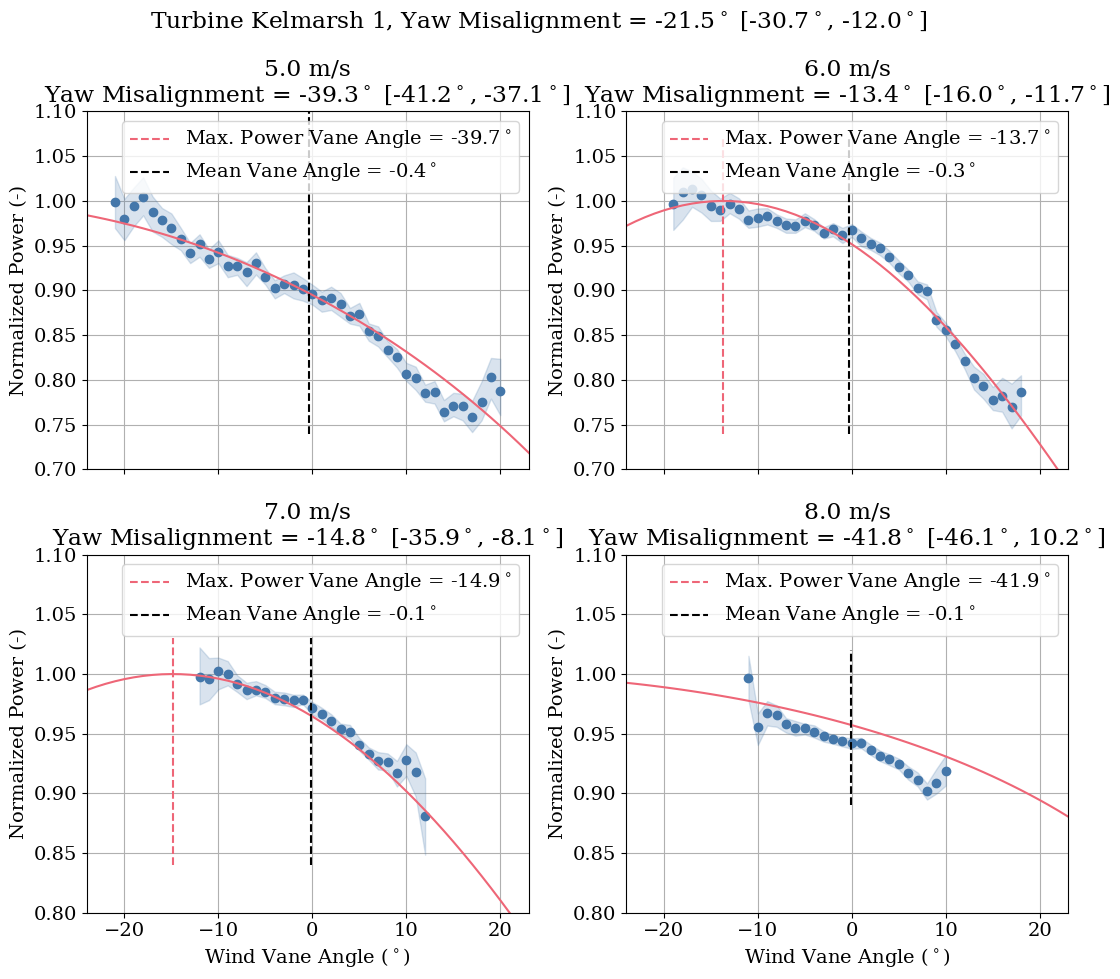

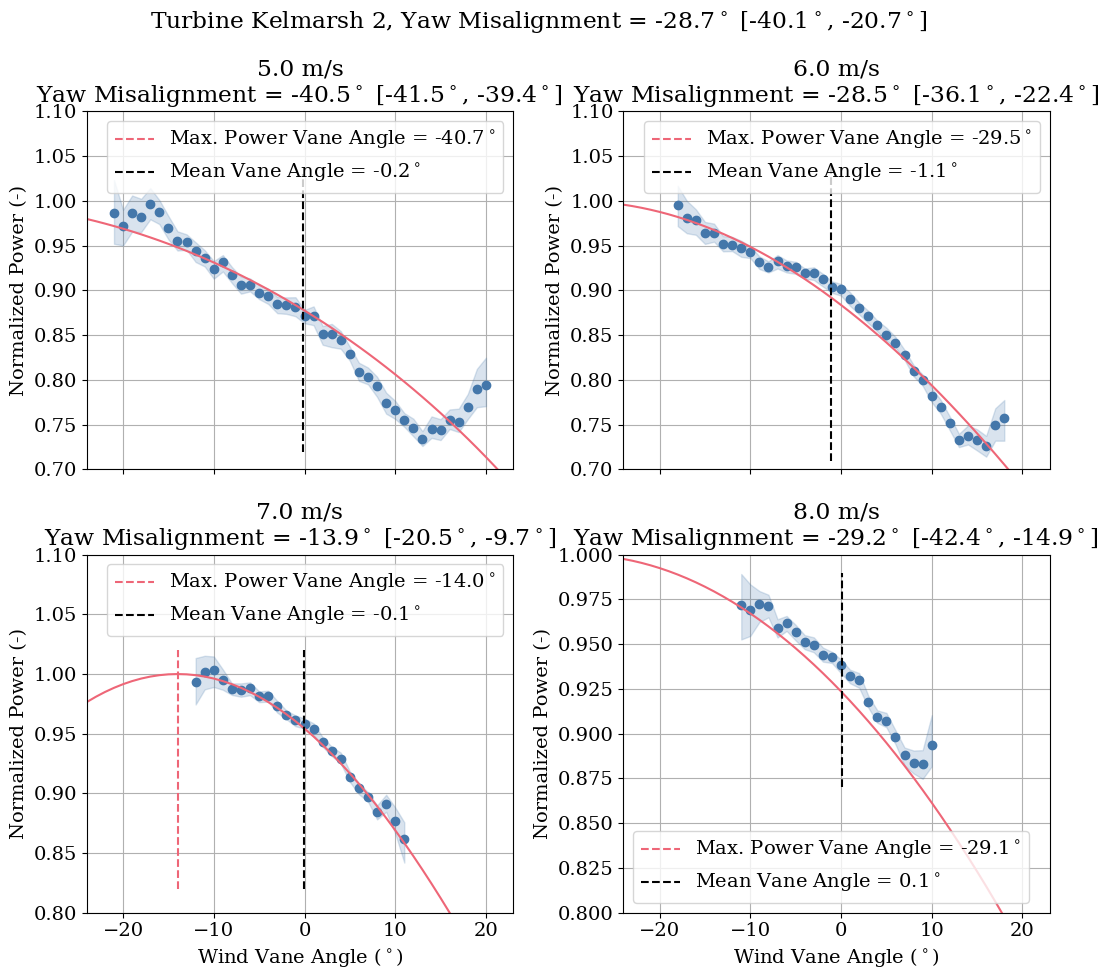

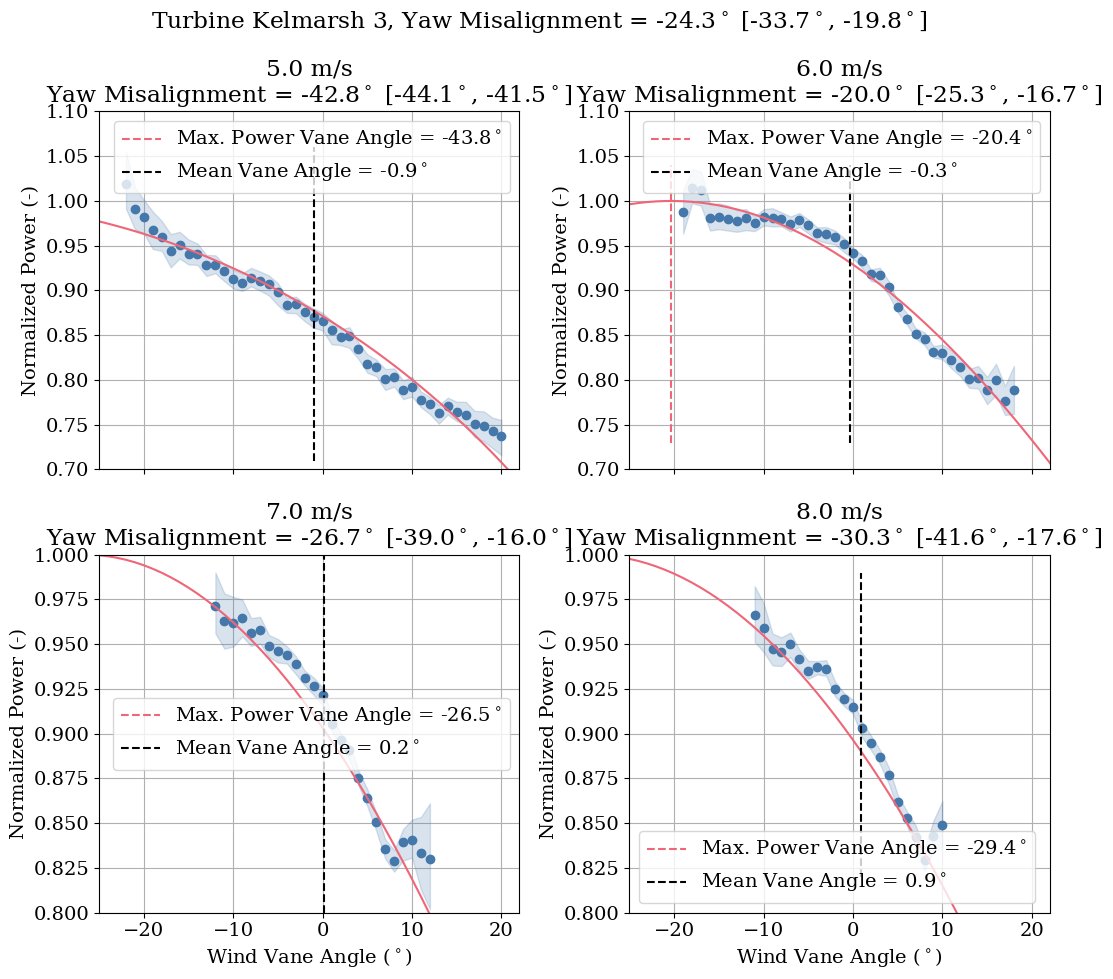

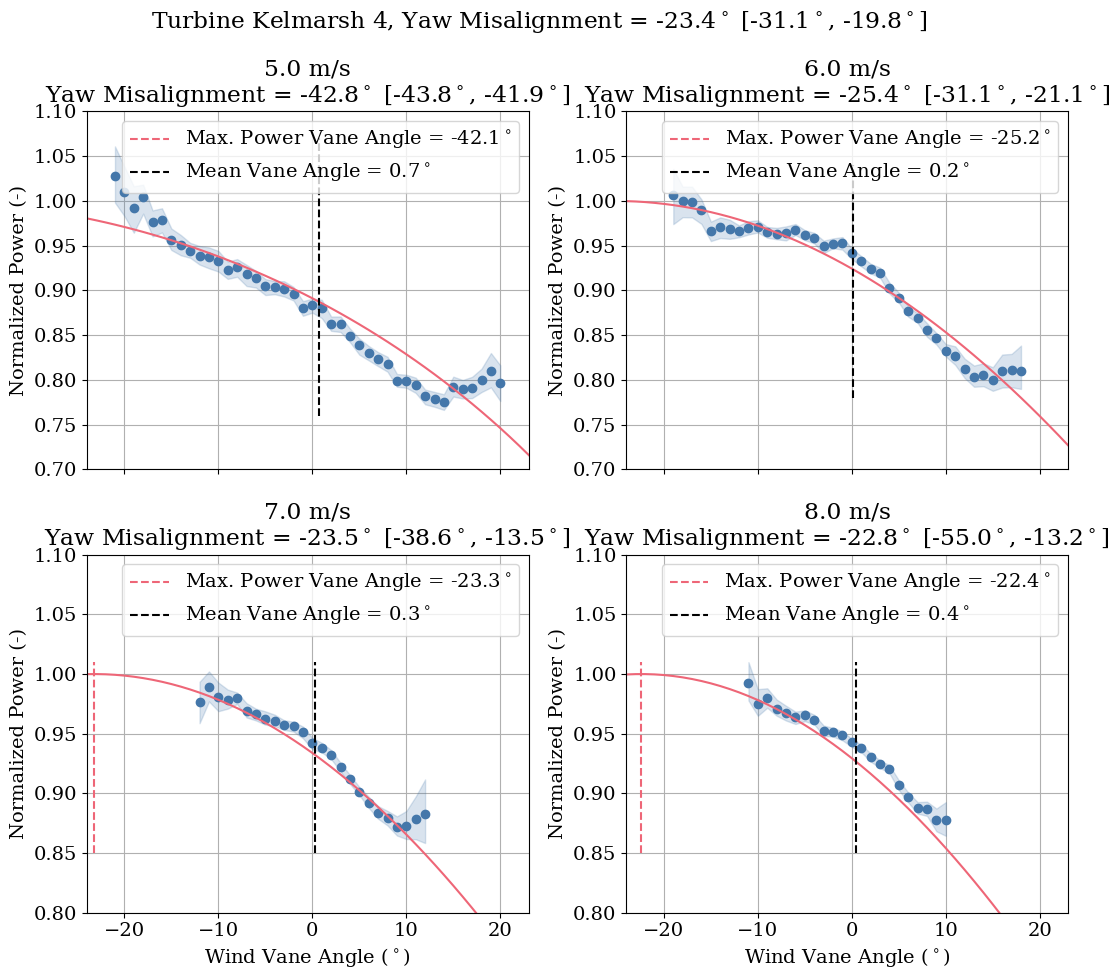

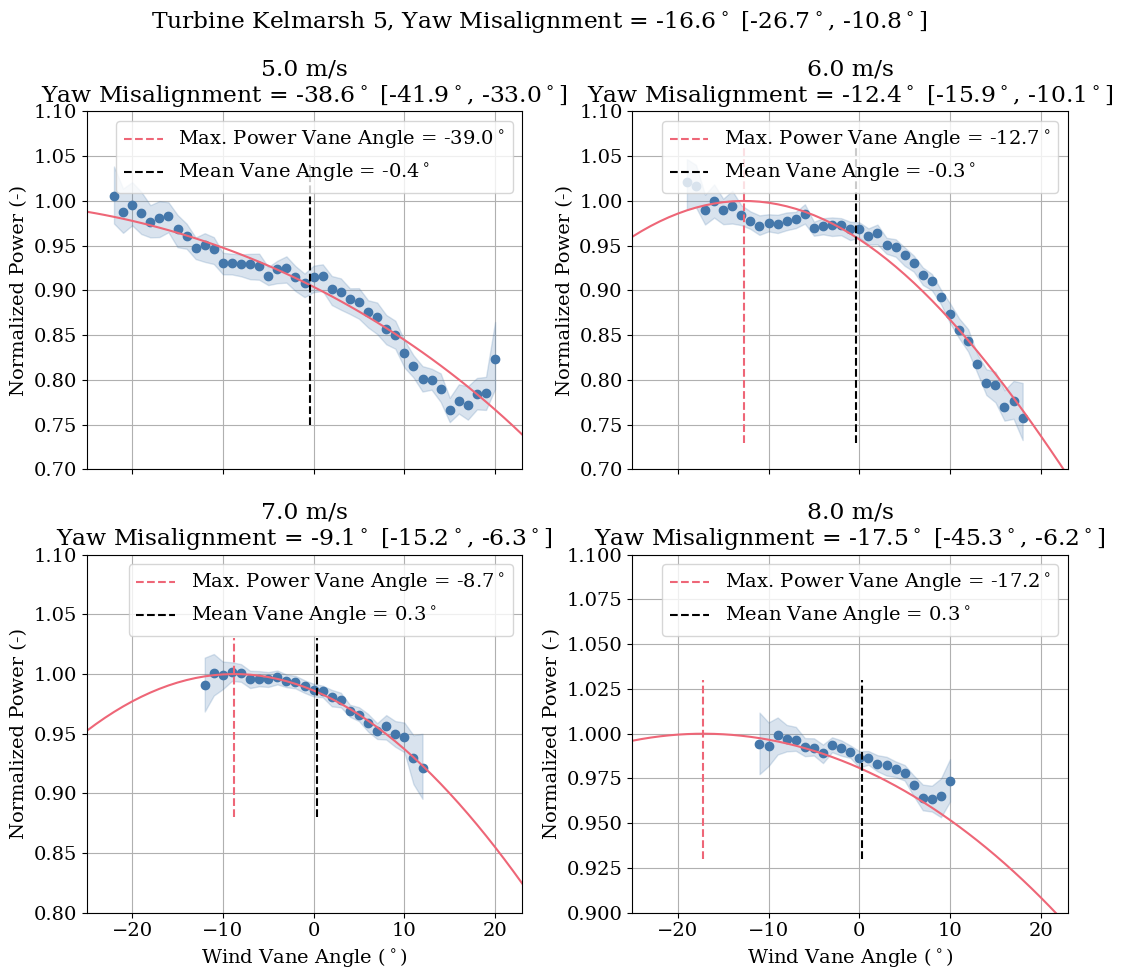

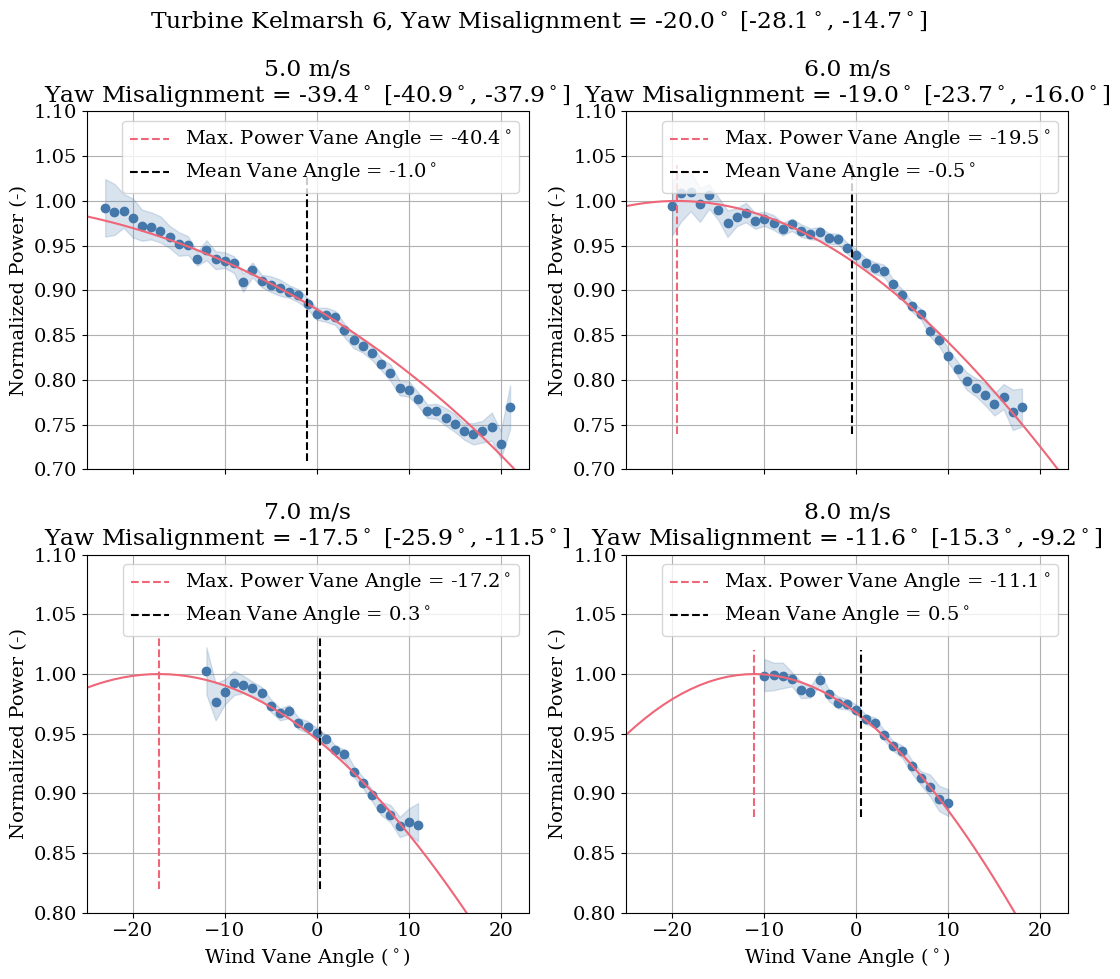

In [16]:
axes_dict = yaw_mis.plot_yaw_misalignment_by_turbine(return_fig = True)

The plots above reveal that yaw misalignment uncertainty increases for higher wind speed bins. This is likely because of the smaller amount of data available at higher wind speeds. In some extreme cases, for turbines R80711 and R80721, the yaw misalignment 95% confidence intervals can span up to 20 degrees or more for high wind speeds (e.g., the 9 m/s and/or 10 m/s bins). This explains the large uncertainty in the overall yaw misalignment for these turbines, although the 95% confidence intervals for lower wind speed bins are reasonable.

Based on the results shown above, it would likely be advantageous to subtract the estimated yaw misalignments from the turbines' wind vane measurements to correct the misalignment. If only one offset can be used for all wind speeds, then the overall yaw misalignment could be subtracted from the vane measurement. But the greatest benefit would come from applying wind speed-dependent corrections, given that relatively small yaw misalignments were estimated for wind speeds below 7-8 m/s and larger offsets were estimated for higher wind speeds. However, the expected benefit of the corrections should be weighed against the effort required to apply the corrections and the uncertainty in the estimated yaw misalignments. For example, if we assume that power production is proportional to the cosine of the yaw misalignment squared, then a 1 degree yaw misalignment would translate to a power loss of only 0.03%, and it may not be worth correcting the wind vane measurements. But for a yaw misalingment of 9 degrees, close to the estimate for turbine R80721 at 9 m/s, the power loss would be 2.5%. Despite the large uncertainty in the true offset, a wind vane correction would likely be well worth the effort in this case.

## Charlie's updates to the methodology

1. Repeat results above
1. Calculate expected generation
1. Use expected vs actual generation binned by wind speed, to determine yaw error as above

### Use this section to allow use of a different pow_ref?

Normalize by wind speed cubed if using power coefficient to determine power performance

        if self.use_power_coeff:
            self._df_turb_ws["pow_ref"] = self._df_turb_ws["WMET_HorWdSpd"].values ** 3
        else:
            self._df_turb_ws["pow_ref"] = 1.0

        self._df_turb_ws["pow_ratio"] = (
            self._df_turb_ws["WTUR_W"].values / self._df_turb_ws["pow_ref"].values
        )

In [17]:
project.scada

WMET_HorWdSpd  WMET_HorWdDir  \
time                asset_id                                   
2016-01-03 00:00:00 Kelmarsh 1            NaN            NaN   
2016-01-03 00:10:00 Kelmarsh 1            NaN            NaN   
2016-01-03 00:20:00 Kelmarsh 1            NaN            NaN   
2016-01-03 00:30:00 Kelmarsh 1            NaN            NaN   
2016-01-03 00:40:00 Kelmarsh 1            NaN            NaN   
...                                       ...            ...   
2021-06-30 23:10:00 Kelmarsh 6           3.17      33.330002   
2021-06-30 23:20:00 Kelmarsh 6           3.64      33.540001   
2021-06-30 23:30:00 Kelmarsh 6           3.53      36.900002   
2021-06-30 23:40:00 Kelmarsh 6           3.10      29.350000   
2021-06-30 23:50:00 Kelmarsh 6           2.36      29.740000   

                                Nacelle position (°)     WTUR_W  WMET_EnvTmp  \
time                asset_id                                                   
2016-01-03 00:00:00 Kelmarsh 1                   NaN        NaN          NaN   
2016-01-03 00:10:00 Kelmarsh 1                   NaN        NaN          NaN   
2016-01-03 00:20:00 Kelmarsh 1                   NaN        NaN          NaN   
2016-01-03 00:30:00 Kelmarsh 1                   NaN        NaN          NaN   
2016-01-03 00:40:00 Kelmarsh 1                   NaN        NaN          NaN   
...                                              ...        ...          ...   
2021-06-30 23:10:00 Kelmarsh 6             34.240002   9.880000          NaN   
2021-06-30 23:20:00 Kelmarsh 6             34.240002  52.250000          NaN   
2021-06-30 23:30:00 Kelmarsh 6             34.240002  40.950001          NaN   
2021-06-30 23:40:00 Kelmarsh 6             34.240002  17.230000          NaN   
2021-06-30 23:50:00 Kelmarsh 6             34.240002 -13.970000          NaN   

                                WROT_BlPthAngVal  WMET_HorWdDirRel  WTUR_SupWh  
time                asset_id                                                    
2016-01-03 00:00:00 Kelmarsh 1               NaN               NaN         NaN  
2016-01-03 00:10:00 Kelmarsh 1               NaN               NaN         NaN  
2016-01-03 00:20:00 Kelmarsh 1               NaN               NaN         NaN  
2016-01-03 00:30:00 Kelmarsh 1               NaN               NaN         NaN  
2016-01-03 00:40:00 Kelmarsh 1               NaN               NaN         NaN  
...                                          ...               ...         ...  
2021-06-30 23:10:00 Kelmarsh 6               NaN          0.910000    1.646667  
2021-06-30 23:20:00 Kelmarsh 6               NaN          0.700001    8.708333  
2021-06-30 23:30:00 Kelmarsh 6               NaN         -2.660000    6.825000  
2021-06-30 23:40:00 Kelmarsh 6               NaN          4.890001    2.871667  
2021-06-30 23:50:00 Kelmarsh 6               NaN          4.500002   -2.328333  

[1733184 rows x 8 columns]

In [18]:
scada_df = project.scada

site_mean = scada_df.groupby("time").mean()

In [19]:
site_mean

WMET_HorWdSpd  WMET_HorWdDir  Nacelle position (°)  \
time                                                                      
2016-01-03 00:00:00            NaN            NaN                   NaN   
2016-01-03 00:10:00            NaN            NaN                   NaN   
2016-01-03 00:20:00            NaN            NaN                   NaN   
2016-01-03 00:30:00            NaN            NaN                   NaN   
2016-01-03 00:40:00            NaN            NaN                   NaN   
...                            ...            ...                   ...   
2021-06-30 23:10:00       3.695000      39.026667             34.291667   
2021-06-30 23:20:00       4.066667      37.478333             35.743334   
2021-06-30 23:30:00       3.990000      37.355000             35.743334   
2021-06-30 23:40:00       3.310000      33.173334             35.743334   
2021-06-30 23:50:00       2.798333      33.553333             35.743334   

                        WTUR_W  WMET_EnvTmp  WROT_BlPthAngVal  \
time                                                            
2016-01-03 00:00:00        NaN          NaN               NaN   
2016-01-03 00:10:00        NaN          NaN               NaN   
2016-01-03 00:20:00        NaN          NaN               NaN   
2016-01-03 00:30:00        NaN          NaN               NaN   
2016-01-03 00:40:00        NaN          NaN               NaN   
...                        ...          ...               ...   
2021-06-30 23:10:00  65.766667          NaN               NaN   
2021-06-30 23:20:00  98.540000          NaN               NaN   
2021-06-30 23:30:00  83.725002          NaN               NaN   
2021-06-30 23:40:00  38.348333          NaN               NaN   
2021-06-30 23:50:00  12.161666          NaN               NaN   

                     WMET_HorWdDirRel  WTUR_SupWh  
time                                               
2016-01-03 00:00:00               NaN         NaN  
2016-01-03 00:10:00               NaN         NaN  
2016-01-03 00:20:00               NaN         NaN  
2016-01-03 00:30:00               NaN         NaN  
2016-01-03 00:40:00               NaN         NaN  
...                               ...         ...  
2021-06-30 23:10:00         -4.734999   10.961111  
2021-06-30 23:20:00         -1.735000   16.423333  
2021-06-30 23:30:00         -1.611666   13.954167  
2021-06-30 23:40:00          2.570000    6.391389  
2021-06-30 23:50:00          2.190001    2.026944  

[288864 rows x 8 columns]

In [20]:
wtg1 = scada_df.loc[(slice(None), "Kelmarsh 1"),
            ["WMET_HorWdSpd", "WTUR_W", "WMET_HorWdDirRel", "WROT_BlPthAngVal"],
            ]

wtg1 = wtg1.droplevel("asset_id")

wtg1["Site_W"] = site_mean["WTUR_W"]
wtg1["Site_HorWdSpd"] = site_mean["WMET_HorWdSpd"]

wtg1["WTUR_W_normalised"] = wtg1["WTUR_W"]/(wtg1["WMET_HorWdSpd"]**3)
wtg1["WTUR_W_site_normalised"] = wtg1["WTUR_W"]/(wtg1["Site_HorWdSpd"]**3)
wtg1["WTUR_W_site_ref"] = wtg1["WTUR_W"]/wtg1["Site_W"]
wtg1["WTUR_HorWdSpd_site_ref"] = wtg1["WMET_HorWdSpd"]/wtg1["Site_HorWdSpd"]

In [21]:
ws_bins=[5.0, 6.0, 7.0, 8.0, 9.0, 10.0]

ws_bin_width=1.0
vane_bin_width=1.0
min_vane_bin_count=50
max_abs_vane_angle=25.0
vane_bins=np.linspace(-25,25,51)

wtg1['ws_bin'] = pd.cut(wtg1['WMET_HorWdSpd'], ws_bins)
wtg1['site_ws_bin'] = pd.cut(wtg1['Site_HorWdSpd'], ws_bins)
wtg1['vane_bin'] = pd.cut(wtg1['WMET_HorWdDirRel'], vane_bins)

In [22]:
wtg1["Site_W"] = site_mean["WTUR_W"]

In [23]:
wtg1.dropna()

WMET_HorWdSpd      WTUR_W  WMET_HorWdDirRel  \
time                                                               
2016-05-03 09:50:00       6.427782  515.468567         -7.515961   
2016-05-03 10:00:00       5.876329  403.398895         -2.333313   
2016-05-03 10:10:00       5.676786  399.778290         -9.639404   
2016-05-03 10:40:00       5.463616  316.062500         -1.038574   
2016-05-03 11:20:00       5.555031  314.388458         -3.454651   
...                            ...         ...               ...   
2021-06-16 04:20:00       6.747309  464.980901          8.752986   
2021-06-16 04:30:00       5.977031  395.865658         -2.561879   
2021-06-16 04:40:00       5.886231  294.169092         -8.155306   
2021-06-16 04:50:00       5.738994  302.087801         -4.643790   
2021-06-16 05:40:00       5.075514  244.213298          0.812407   

                     WROT_BlPthAngVal      Site_W  Site_HorWdSpd  \
time                                                               
2016-05-03 09:50:00          0.098996  422.353210       6.203754   
2016-05-03 10:00:00          0.000000  255.464389       5.257882   
2016-05-03 10:10:00          0.049000  348.509306       5.524859   
2016-05-03 10:40:00          0.000000  250.525979       5.043280   
2016-05-03 11:20:00          0.049000  219.997381       5.159114   
...                               ...         ...            ...   
2021-06-16 04:20:00          0.000000  292.533650       5.225375   
2021-06-16 04:30:00          0.000000  295.386570       5.489586   
2021-06-16 04:40:00          0.000000  273.316411       5.477473   
2021-06-16 04:50:00          0.000000  275.606493       5.442343   
2021-06-16 05:40:00          0.000000  242.357013       5.288940   

                     WTUR_W_normalised  WTUR_W_site_normalised  \
time                                                             
2016-05-03 09:50:00           1.940970                2.158929   
2016-05-03 10:00:00           1.988000                2.775250   
2016-05-03 10:10:00           2.185303                2.370586   
2016-05-03 10:40:00           1.937905                2.463960   
2016-05-03 11:20:00           1.834033                2.289503   
...                                ...                     ...   
2021-06-16 04:20:00           1.513712                3.258987   
2021-06-16 04:30:00           1.853921                2.392925   
2021-06-16 04:40:00           1.442398                1.790014   
2021-06-16 04:50:00           1.598181                1.874025   
2021-06-16 05:40:00           1.867795                1.650682   

                     WTUR_W_site_ref  WTUR_HorWdSpd_site_ref      ws_bin  \
time                                                                       
2016-05-03 09:50:00         1.220468                1.036112  (6.0, 7.0]   
2016-05-03 10:00:00         1.579081                1.117623  (5.0, 6.0]   
2016-05-03 10:10:00         1.147109                1.027499  (5.0, 6.0]   
2016-05-03 10:40:00         1.261596                1.083346  (5.0, 6.0]   
2016-05-03 11:20:00         1.429055                1.076741  (5.0, 6.0]   
...                              ...                     ...         ...   
2021-06-16 04:20:00         1.589495                1.291258  (6.0, 7.0]   
2021-06-16 04:30:00         1.340161                1.088795  (5.0, 6.0]   
2021-06-16 04:40:00         1.076295                1.074625  (5.0, 6.0]   
2021-06-16 04:50:00         1.096084                1.054508  (5.0, 6.0]   
2021-06-16 05:40:00         1.007659                0.959647  (5.0, 6.0]   

                    site_ws_bin       vane_bin  
time                                            
2016-05-03 09:50:00  (6.0, 7.0]   (-8.0, -7.0]  
2016-05-03 10:00:00  (5.0, 6.0]   (-3.0, -2.0]  
2016-05-03 10:10:00  (5.0, 6.0]  (-10.0, -9.0]  
2016-05-03 10:40:00  (5.0, 6.0]   (-2.0, -1.0]  
2016-05-03 11:20:00  (5.0, 6.0]   (-4.0, -3.0]  
...                         ...            ...  
2021-06-16 

  wtg1.groupby(by=["ws_bin","vane_bin"], dropna=True)["WTUR_W"].mean().plot()



<Axes: xlabel='ws_bin,vane_bin'>

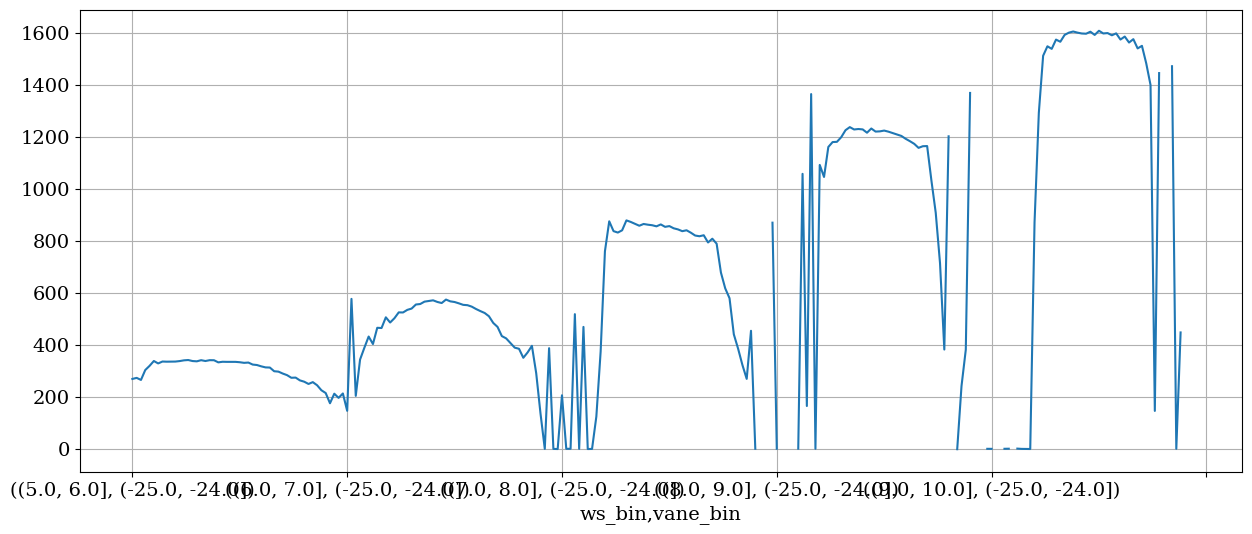

In [24]:
wtg1.groupby(by=["ws_bin","vane_bin"], dropna=True)["WTUR_W"].mean().plot()

  wtg1.groupby(by=["ws_bin","vane_bin"], dropna=True)["WTUR_W_normalised"].mean().plot()



<Axes: xlabel='ws_bin,vane_bin'>

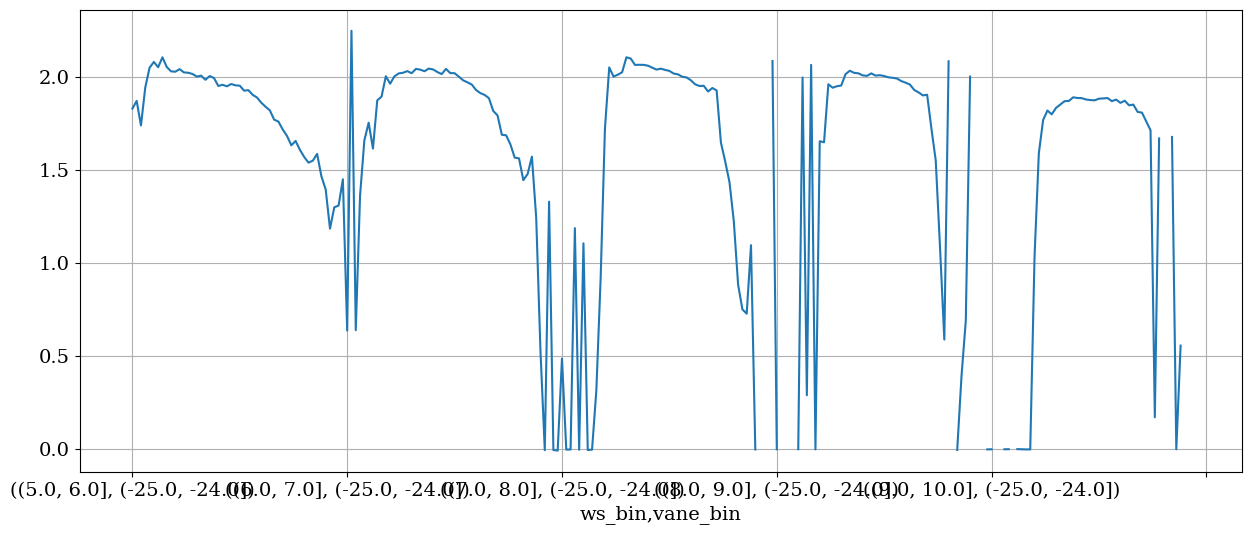

In [25]:
wtg1.groupby(by=["ws_bin","vane_bin"], dropna=True)["WTUR_W_normalised"].mean().plot()

  wtg1.groupby(by=["site_ws_bin","vane_bin"], dropna=True)["WTUR_W"].mean().plot()



<Axes: xlabel='site_ws_bin,vane_bin'>

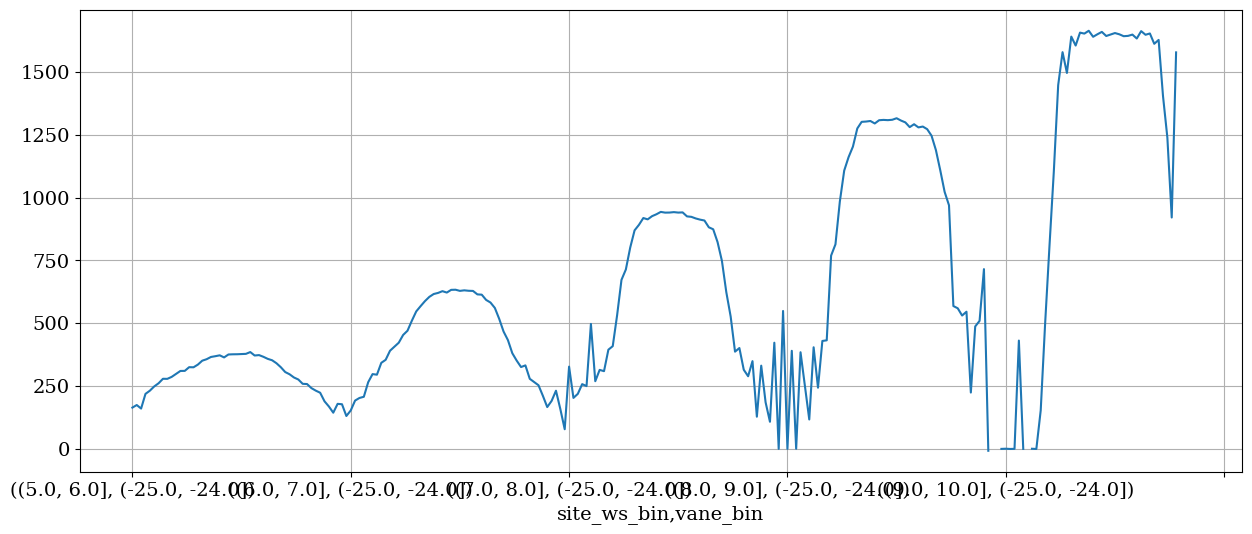

In [26]:
wtg1.groupby(by=["site_ws_bin","vane_bin"], dropna=True)["WTUR_W"].mean().plot()

  wtg1.groupby(by=["site_ws_bin","vane_bin"], dropna=True)["WTUR_W_site_normalised"].mean().plot()



<Axes: xlabel='site_ws_bin,vane_bin'>

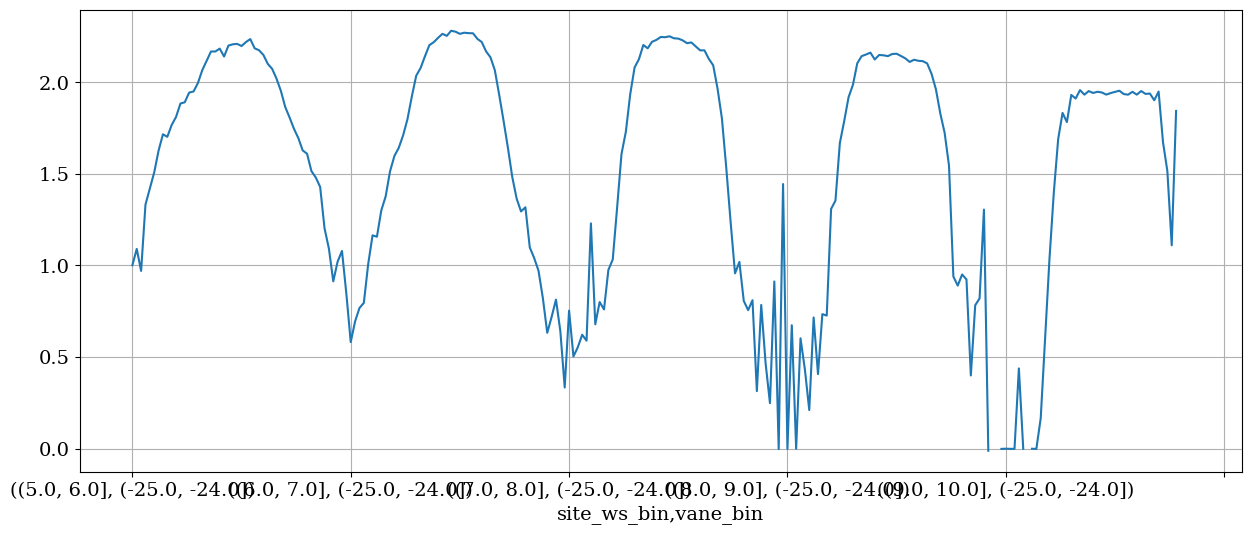

In [27]:
wtg1.groupby(by=["site_ws_bin","vane_bin"], dropna=True)["WTUR_W_site_normalised"].mean().plot()

  wtg1.groupby(by=["site_ws_bin","vane_bin"], dropna=True)["WTUR_W_site_ref"].mean().plot()



<Axes: xlabel='site_ws_bin,vane_bin'>

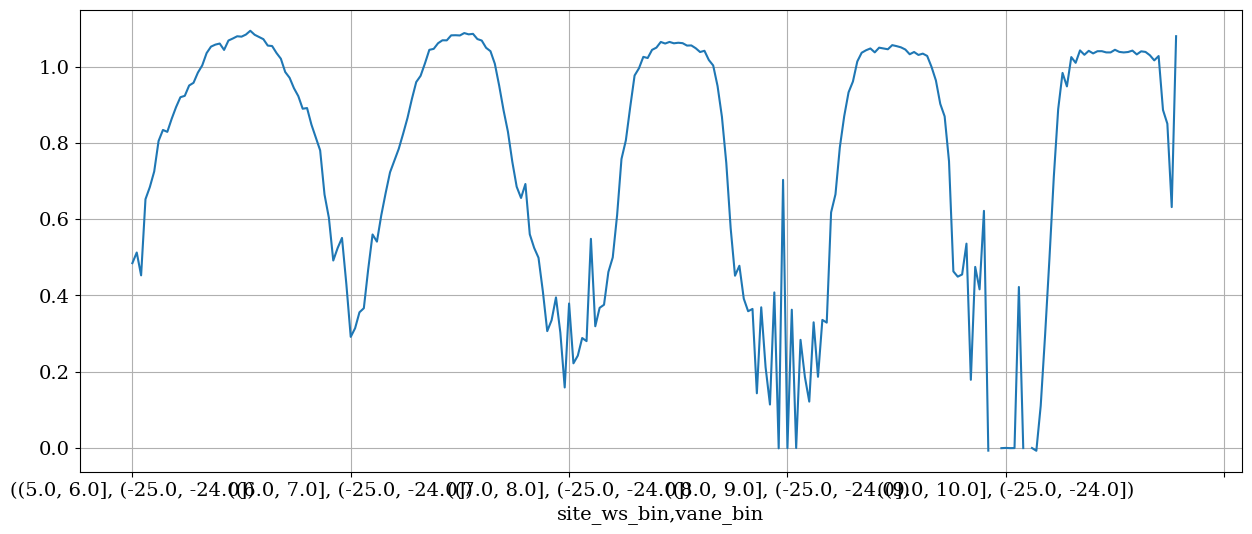

In [28]:
wtg1.groupby(by=["site_ws_bin","vane_bin"], dropna=True)["WTUR_W_site_ref"].mean().plot()

  wtg1.groupby(by=["site_ws_bin","vane_bin"], dropna=True)["WTUR_HorWdSpd_site_ref"].mean().plot()



<Axes: xlabel='site_ws_bin,vane_bin'>

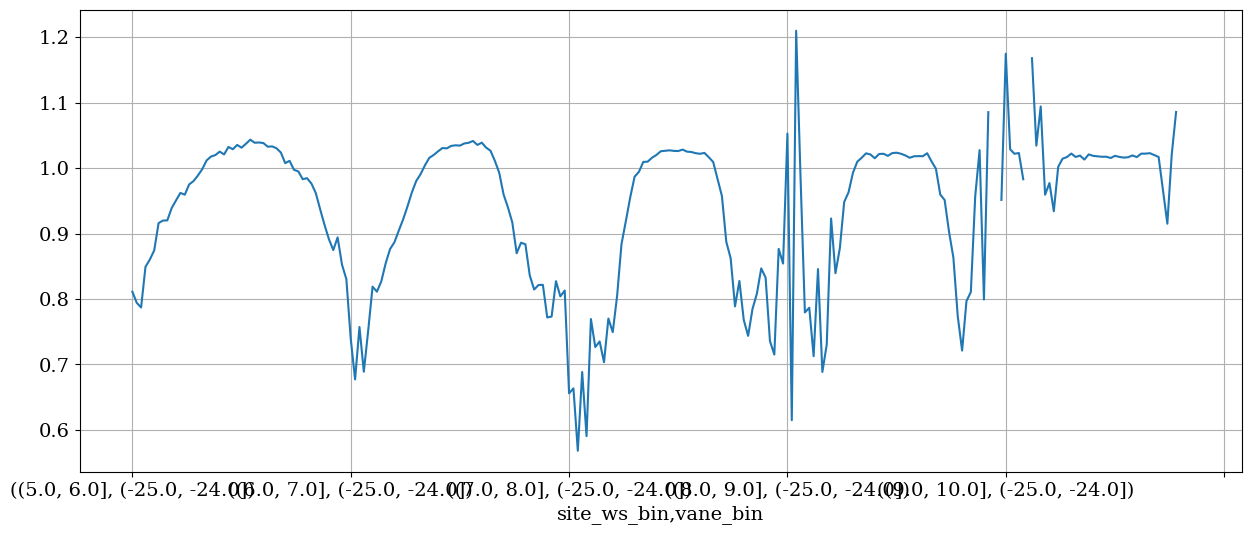

In [29]:
wtg1.groupby(by=["site_ws_bin","vane_bin"], dropna=True)["WTUR_HorWdSpd_site_ref"].mean().plot()